In [ ]:
import pandas as pd
import requests
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import gaussian_kde

import warnings

# FutureWarning 무시 설정
warnings.filterwarnings("ignore", category=FutureWarning)



#### 사용된 함수 정리

In [ ]:
# assistingParticipantIds 값을 해당하는 teamposition으로 변경

def replace_ids_with_names(ids ,match_id):

    if isinstance(ids, list):
        return [team_info.loc[(team_info['killerId'] == id) & (team_info['matchId'] == match_id), 'killerPosition'].values[0] if pd.notna(id) else None for id in ids]
    else:
        return None



# 라인을 머문 점수 계산
def calculate_lane(x, y):
    top_ranges = [(500, 2000, 6000, 14000),(600, 9000, 13000, 14500), (1900,4500,11100,13100)]

    bottom_ranges = [(6000, 14000, 500, 2000),(13000,14500, 500,9000),(10500,13000,2000,3800)]

    mid_ranges = [(4500, 6000, 4500, 6000),(5200,6700,5200,6700),(5900,7400,5900,7400),(6000,8500,6000,8500),
                  (7300,8800,7300,8800),(8000,9500,8000,9500),(8700,10200,8700,10200),(9200,10500,9200,10500)]

    blue_zone = [(0,4500,0,4500)]
    red_zone = [(10500,15000,10500,15000)]

    for range_ in top_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'TOP'
    for range_ in mid_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'MIDDLE'
    for range_ in bottom_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'BOTTOM'
    for range_ in blue_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'blue_zone'
    for range_ in red_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'red_zone'
    return 'JUNGLE' # 나머지는 jungle




# 좌표 데이터 추출
def death_spot(df):

    x_data = df['position'].apply(lambda pos: pos['x'])
    y_data = df['position'].apply(lambda pos: pos['y'])

    # 밀도 플롯을 위한 데이터 생성
    # xy = np.vstack([x_data, y_data])
    # z = gaussian_kde(xy)(xy)

    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 15000)
    ax.set_ylim(0, 15000)
    plt.axis('off')

    # 지도 이미지 추가
    map_path = "/content/map.jpg"
    img = Image.open(map_path)
    ax.imshow(img, extent=[0, 15000, 0, 15000])

    colors = np.where(df['teamId'] == 100, '#459ae5', '#ed4141')
    sc = ax.scatter(x_data, y_data, c=colors, s=30, alpha=0.7, edgecolors='none')

    plt.show()



# 데미지로 집계 (받은피해량) - 데스 기준
def received_damage(all_death_log, damage_col, position):
  all_death_log = all_death_log[~all_death_log['victimDamageDealt'].isna()]
  death_list = []
  if not all_death_log.empty:
      for d, ts, id, p in zip(all_death_log[damage_col], all_death_log['timestamp'],all_death_log['matchId'],all_death_log[position]):
          df = pd.json_normalize(d)
          df['timestamp'] = ts
          df['matchId'] = id
          df[position] = p
          death_list.append(df)

      death_damage_log = pd.concat(death_list, axis=0)
      death_damage_log = death_damage_log[['matchId','timestamp','name',position,'participantId','spellName','magicDamage','physicalDamage','trueDamage']]
      death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)
      death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage'] + death_damage_log['trueDamage']
  else:
      death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name',position,'participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])
      death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage'] + death_damage_log['trueDamage']

  return  death_damage_log



def damage (df):
  death_list = []
  if not df.empty:
      for d, ts, id, vicitmId  in zip(df['victimDamageReceived'], df['timestamp'],df['matchId'],df['victimId']):
          df = pd.json_normalize(d)
          df['timestamp'] = ts
          df['matchId'] = id
          df['victimId'] = vicitmId
          death_list.append(df)

      death_damage_log = pd.concat(death_list, axis=0)
      death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','spellName','magicDamage','physicalDamage','trueDamage','victimId']]
      death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)
      death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage'] + death_damage_log['trueDamage']
      death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','totalDamage','victimId']]
      death_damage_log.columns = ['matchId','timestamp','championName','killerId','totalDamage','victimId']

  else:
      death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage','victimId'])
      death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage'] + death_damage_log['trueDamage']
      death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','totalDamage','victimId']]
      death_damage_log.columns = ['matchId','timestamp','championName','killerId','totalDamage','victimId']

  return death_damage_log


# 데이터 수집


* 15분 이상 진행된 미드라이너 경기

In [ ]:
def get_puuid(summoner_name, api_key):
    # Get summoner puuid
    sohwan = "https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}"
    url = sohwan.format(summoner_name, api_key)
    response = requests.get(url)
    puuid = response.json()['puuid']
    summoner_id = response.json()['id']
    iconId = response.json()['profileIconId']

    return puuid, summoner_id, iconId,


def get_match_ids(puuid, api_key, start= 0, count= 10):
    # Get match ids
    matchid_url = "https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?type=ranked&start={}&count={}&api_key={}"
    url = matchid_url.format(puuid, start, count, api_key)
    response = requests.get(url)
    match_ids = response.json()
    return match_ids


def get_match_data_logs(match_ids,api_key):
    # Get match data for each match id
    match_data_logs = []
    time_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}/timeline?api_key={}'
    for i, match_id in enumerate(match_ids):
        url = time_url.format(match_id, api_key)
        response = requests.get(url)
        match_data_logs.append(pd.DataFrame(response.json()))

    return  match_data_logs


summoner_name = '메시아빠우왁굳'
api_key = 'RGAPI-'

puuid, summoner_id, iconId = get_puuid(summoner_name, api_key)
match_ids = get_match_ids(puuid, api_key)
match_data_logs = get_match_data_logs(match_ids, api_key)


In [ ]:
# match_v5 (경기가 끝나고 나오는 통계요약)
def get_match_v5(match_ids, api_key):
    url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'
    match_info_list = []
    champion_info_list = []

    for match_id in match_ids:
        response = requests.get(url.format(match_id, api_key))
        match_df = pd.DataFrame(response.json())

        try:
            df = pd.DataFrame(match_df['info']['participants'])
        except KeyError:
            print(f"KeyError: 'info' key not found in match_df for matchId {match_id}. Skipping...")
            continue

        sample = df[['teamId', 'puuid', 'summonerName', 'participantId', 'teamPosition', 'challenges', 'summoner1Id', 'summoner2Id',
            'championName', 'lane', 'kills', 'deaths', 'assists', 'totalMinionsKilled', 'neutralMinionsKilled', 'goldEarned', 'goldSpent', 'champExperience', 'item0', 'item1', 'item2',
            'item3', 'item4', 'item5', 'item6', 'totalDamageDealt', 'totalDamageDealtToChampions', 'totalDamageTaken', 'damageDealtToTurrets', 'damageDealtToBuildings',
            'totalTimeSpentDead', 'longestTimeSpentLiving', 'visionScore', 'win', 'timePlayed', 'damageSelfMitigated', 'totalDamageShieldedOnTeammates','gameEndedInEarlySurrender',
            'totalHealsOnTeammates', 'damageDealtToObjectives']]

        challenge = pd.DataFrame(sample['challenges'].tolist())

        col = challenge[['soloKills', 'multikills', 'abilityUses', 'damageTakenOnTeamPercentage', 'skillshotsDodged', 'skillshotsHit', 'enemyChampionImmobilizations', 'laneMinionsFirst10Minutes','controlWardsPlaced'
                        , 'visionScorePerMinute', 'wardTakedowns', 'effectiveHealAndShielding', 'dragonTakedowns', 'baronTakedowns', 'teamBaronKills']]
        jungle_and_etc_col = challenge.filter(regex='^jungle|Jungle|kda|ward|Per')

        match_info = pd.concat([sample, col, jungle_and_etc_col], axis=1)
        match_info['summonerName'] = match_info.apply(lambda row: row['puuid'][:10] if row['summonerName'].strip() == '' else row['summonerName'], axis=1)
        match_info['totalCS'] = match_info['totalMinionsKilled'] + match_info['neutralMinionsKilled']
        match_info['matchId'] = match_df['metadata']['matchId']
        match_info['championName'] = match_info['championName'].apply(lambda x: 'Fiddlesticks' if x == 'FiddleSticks' else x)  # 피들스틱 에러
        match_info.loc[match_info['summonerName'] == '우왁굳', 'summonerName'] = '돈까스'

        champion_info = match_info[['win','matchId', 'participantId', 'teamId', 'teamPosition', 'summonerName', 'puuid', 'championName']]

        match_info['win_kr'] = match_info['win'].apply(lambda x: '승리' if x == 1 else '패배')
        match_info['totalCS10Minutes'] = match_info['laneMinionsFirst10Minutes'] + match_info['jungleCsBefore10Minutes']

        # 각각의 데이터를 리스트에 추가
        match_info_list.append(match_info)
        champion_info_list.append(champion_info)

        match_info = pd.concat(match_info_list, ignore_index=True)
        champion_info = pd.concat(champion_info_list, ignore_index=True)


    return match_info, champion_info


match_info, champion_info = get_match_v5(match_ids,api_key)


KeyError: 'info' key not found in match_df for matchId KR_6920109445. Skipping...


In [ ]:
match_info[match_info['puuid']== puuid]

,teamId,puuid,summonerName,participantId,teamPosition,challenges,summoner1Id,summoner2Id,championName,lane,kills,deaths,assists,totalMinionsKilled,neutralMinionsKilled,goldEarned,goldSpent,champExperience,item0,item1,item2,item3,item4,item5,item6,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,damageDealtToTurrets,damageDealtToBuildings,totalTimeSpentDead,longestTimeSpentLiving,visionScore,win,timePlayed,damageSelfMitigated,totalDamageShieldedOnTeammates,gameEndedInEarlySurrender,totalHealsOnTeammates,damageDealtToObjectives,soloKills,multikills,abilityUses,damageTakenOnTeamPercentage,skillshotsDodged,skillshotsHit,enemyChampionImmobilizations,laneMinionsFirst10Minutes,controlWardsPlaced,visionScorePerMinute,wardTakedowns,effectiveHealAndShielding,dragonTakedowns,baronTakedowns,teamBaronKills,alliedJungleMonsterKills,enemyJungleMonsterKills,epicMonsterKillsNearEnemyJungler,getTakedownsInAllLanesEarlyJungleAsLaner,jungleCsBefore10Minutes,junglerTakedownsNearDamagedEpicMonster,kda,killsOnOtherLanesEarlyJungleAsLaner,moreEnemyJungleThanOpponent,takedownsBeforeJungleMinionSpawn,wardTakedowns,wardTakedownsBefore20M,wardsGuarded,junglerKillsEarlyJungle,killsOnLanersEarlyJungleAsJungler,totalCS,matchId,win_kr,totalCS10Minutes
0,100,GD8gmDI442kEOdm6Zp7pC2I5B0AnsbYnBWjzN6tohCCEg6...,상현0919,1,TOP,"{'12AssistStreakCount': 0, 'abilityUses': 167,...",12,4,Ornn,JUNGLE,0,7,10,112,0,6900,6400,12065,1054,3076,7025,1001,1031,6660,3340,97999,18529,36131,1953,1953,199,790,8,False,1694,30340,0,False,0,3114,0,0,167,0.252263,59,33,44,43,0,0.302757,0,0.0,0,0,0,0,0,0,0.0,0.0,0,1.428571,0.0,0.0,0,0,0,1,NaN,NaN,112,KR_6918757013,패배,43.0
1,100,mEb0LTVcFDe4n4pGsIBPk-EFhc6cNr3xb0BFbd1r7DMi4Y...,퀴퀘그,2,JUNGLE,"{'12AssistStreakCount': 0, 'abilityUses': 441,...",11,4,LeeSin,JUNGLE,4,5,10,11,96,8984,8650,10186,3071,6610,3047,2021,0,0,3340,148333,12636,35547,0,0,147,683,30,False,1694,28576,1150,False,0,13710,0,0,441,0.248184,49,21,16,2,2,1.067063,2,1150.0,0,0,0,44,7,1,NaN,38.0,0,2.800000,NaN,-37.0,0,2,1,0,0.0,1.0,107,KR_6918757013,패배,40.0
2,100,v1_7jguW_mlFlBgM7wb07H-iRvksYtR3Zed2o61fdjSpQR...,욕먹으면 앙 쥬금,3,MIDDLE,"{'12AssistStreakCount': 0, 'abilityUses': 210,...",12,4,Akali,MIDDLE,12,8,6,168,0,13497,12800,13817,2420,4645,2055,4646,7012,3020,3340,109398,28216,28102,745,745,261,540,22,False,1694,14069,0,False,0,745,2,2,210,0.196209,52,51,0,75,1,0.813968,0,0.0,0,0,0,0,0,0,0.0,0.0,0,2.250000,1.0,0.0,0,0,0,0,NaN,NaN,168,KR_6918757013,패배,75.0
3,100,8O4aajksxYpOEJ1OeW0dR_FmPLMznao9iEZVKh6Rx5Q0Kt...,섹시민기,4,BOTTOM,"{'12AssistStreakCount': 0, 'abilityUses': 100,...",7,4,Lucian,BOTTOM,5,8,13,132,0,10290,9200,10232,6672,6675,1055,3086,1036,3006,3340,90476,15944,21463,1597,1597,168,375,9,False,1694,8241,0,False,454,1597,1,2,100,0.149856,60,12,0,40,0,0.324984,1,454.0,0,0,0,0,0,0,0.0,0.0,0,2.250000,0.0,0.0,0,1,1,0,NaN,NaN,132,KR_6918757013,패배,40.0
4,100,JZqxqueUcFITYP3u1KVyOs4FYpzT1jw0Wa4lyTrE4uw-OJ...,농구하는 포비,5,UTILITY,"{'12AssistStreakCount': 0, 'abilityUses': 127,...",14,4,Pyke,BOTTOM,10,10,10,41,0,11498,11000,12666,3877,6696,3179,3814,3158,3035,3364,33365,13384,21984,829,829,211,380,20,False,1694,11560,0,False,0,829,3,2,127,0.153488,80,24,20,14,0,0.713664,3,0.0,0,0,0,0,0,0,0.0,0.0,0,2.000000,0.0,0.0,0,3,1,0,NaN,NaN,41,KR_6918757013,패배,14.0


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# champion_info['matchId'].nunique()


In [ ]:
# 15분 초과의 경기만

def matchId_by_position (match_info, puuid ): # position
  match_info = match_info[(match_info['timePlayed'] > 1200) & (match_info['puuid']==puuid) ] # & (match_info['teamPosition'] == position)
  matchId_list = match_info['matchId'].drop_duplicates().tolist()
  return matchId_list

matchId_list = matchId_by_position(match_info,puuid) # 48
match_info = match_info[match_info['matchId'].isin(matchId_list)]



In [ ]:
# FAKER 지표
# match_info['totalTimeSpentDead'] = match_info['totalTimeSpentDead']/60
# mid_faker = match_info[match_info['teamPosition'] == 'MIDDLE']
# indicators = ['totalCS10Minutes','totalTimeSpentDead','visionScore','wardTakedowns','controlWardsPlaced','soloKills','kda','totalDamageDealtToChampions','damageDealtToObjectives','multikills']
# faker = round(pd.DataFrame(mid_faker[mid_faker['puuid']==puuid][indicators].mean().rename('faker')).reset_index().rename(columns={'index': 'col'}),2)
# # faker_data = faker.to_dict('records')
# faker

In [ ]:
match_info['totalCS10Minutes'] = match_info['laneMinionsFirst10Minutes'] + match_info['jungleCsBefore10Minutes']

<ipython-input-6-20e06732bc75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_info['totalCS10Minutes'] = match_info['laneMinionsFirst10Minutes'] + match_info['jungleCsBefore10Minutes']


In [ ]:
summoner_match_info = match_info[(match_info['puuid'] == puuid)] # &(match_info['teamPosition'] == 'MIDDLE')
other_line_info = match_info[(match_info['puuid'] != puuid)&(match_info['teamPosition'] == 'MIDDLE')]

team_line_info = (
    match_info.groupby(['matchId', 'teamId'])
      .filter(lambda x: any(x['summonerName'] == summoner_name))
)


In [ ]:
# 챔피언별 통계
summoner_champ_static = summoner_match_info.groupby(['championName']).agg(
                        champion_count = pd.NamedAgg(column = 'championName', aggfunc='count'),
                        soloKills_sum = pd.NamedAgg(column = 'soloKills', aggfunc='sum'),
                        win_sum = pd.NamedAgg(column = 'win', aggfunc='sum'),
                        # timeplayed_mean = pd.NamedAgg(column = 'timePlayed', aggfunc='mean'),
                        totalCS10Minutes_mean = pd.NamedAgg(column = 'totalCS10Minutes', aggfunc='mean')).sort_values(by=['champion_count'], ascending=False).reset_index()
summoner_champ_static

,championName,champion_count,soloKills_sum,win_sum,totalCS10Minutes_mean
0,Zed,13,31,6,52.692308
1,Azir,7,9,3,51.857143
2,Galio,4,2,3,55.250000
3,Katarina,4,7,1,47.750000
4,Ezreal,3,0,2,47.333333
5,Hwei,3,4,1,60.333333
6,Akali,2,0,0,47.500000
7,Caitlyn,2,2,2,51.000000
8,Morgana,2,4,1,55.500000
9,Zoe,2,0,1,49.000000


In [ ]:
champion_info

In [ ]:
# 유저의 랭크 , 승패
def get_rank_info (summoner_id, api_key):
    rank_info = "https://kr.api.riotgames.com/lol/league/v4/entries/by-summoner/{}?api_key={}"
    url = rank_info.format(summoner_id, api_key)
    response = requests.get(url)
    rank_data = response.json()

    return rank_data


rank_data = get_rank_info(summoner_id,api_key)
rank_data

[{'leagueId': '938c6c81-8a9f-46bd-82da-44d0d066bb6e',
  'queueType': 'RANKED_SOLO_5x5',
  'tier': 'IRON',
  'rank': 'III',
  'summonerId': 'BpLMTYwLBEmcLZCK9QCYNJxtFss7bvN0GSTlb6TJ55Bpjcc',
  'summonerName': '메시아빠우왁굳',
  'leaguePoints': 0,
  'wins': 7,
  'losses': 11,
  'veteran': False,
  'inactive': False,
  'freshBlood': True,
  'hotStreak': False}]

### 최근 20경기 지표 (평균)
* 상대라이너 기준
* 팀원 평균 기준


In [ ]:
match_info['timePlayed'] = match_info['timePlayed']/60

In [ ]:
# len(match_info[(match_info['timePlayed'] < 35) & (match_info['timePlayed'] > 14)]['matchId'].unique())

len(match_info[match_info['timePlayed'] > 15]['matchId'].unique())

# import seaborn as sns

# # 분포 확인
# fig, ax = plt.subplots(nrows=1, figsize=(8,5))
# sns.distplot(match_info['timePlayed'], hist=False)
# plt.subplots_adjust(hspace=1)
# plt.show()



46

In [ ]:
# 왁굳님의 대표 게임지표 (평균)
wak_score = summoner_match_info[['summonerName','visionScore','soloKills','totalCS10Minutes',
                    'totalDamageDealtToChampions','damageDealtToBuildings']]
opponent_score = other_line_info[['summonerName','visionScore','soloKills','totalCS10Minutes',
                        'totalDamageDealtToChampions','damageDealtToBuildings']]

wak_vs_df = pd.concat([wak_score,opponent_score])
wak_vs_df.loc[wak_vs_df['summonerName']!= summoner_name, 'summonerName'] = '상대라이너'


normalization_df = (wak_vs_df - wak_vs_df.min(numeric_only=True))/(wak_vs_df.max(numeric_only=True) - wak_vs_df.min(numeric_only=True))
normalization_df['summonerName'] = wak_vs_df['summonerName']

z = normalization_df.groupby(['summonerName']).agg(
      totalDamageDealtToChampions= pd.NamedAgg(column = 'totalDamageDealtToChampions', aggfunc='mean'),
      totalCS10Minutes = pd.NamedAgg(column = 'totalCS10Minutes', aggfunc='mean'),
      soloKills = pd.NamedAgg(column = 'soloKills', aggfunc='mean'),
      visionScore = pd.NamedAgg(column = 'visionScore', aggfunc='mean'),
      damageDealtToBuildings = pd.NamedAgg(column = 'damageDealtToBuildings', aggfunc='mean'),
).reset_index()


melted_df = pd.melt(z, id_vars=["summonerName"], var_name="var", value_name="value")
pivoted_df = melted_df.pivot(index="var", columns="summonerName", values="value").reset_index()
radar_data = pivoted_df.to_dict("records")

radar_data

[{'var': 'damageDealtToBuildings',
  '메시아빠우왁굳': 0.21760340842022427,
  '상대라이너': 0.2368426160056783},
 {'var': 'soloKills',
  '메시아빠우왁굳': 0.11956521739130435,
  '상대라이너': 0.23692810457516342},
 {'var': 'totalCS10Minutes',
  '메시아빠우왁굳': 0.4107142857142857,
  '상대라이너': 0.5777310924369748},
 {'var': 'totalDamageDealtToChampions',
  '메시아빠우왁굳': 0.3366015916100501,
  '상대라이너': 0.3535148577133843},
 {'var': 'visionScore',
  '메시아빠우왁굳': 0.40084835630965004,
  '상대라이너': 0.42324246771879487}]

### 우왁굳님의 주요 라인 및 챔피언

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

print(summoner_match_info['teamPosition'].value_counts())
print(summoner_match_info['championName'].value_counts())

MIDDLE    41
BOTTOM     5
Name: teamPosition, dtype: int64
Zed         15
Azir         6
Galio        4
Morgana      3
Katarina     3
Caitlyn      2
Ezreal       2
Zoe          2
Akali        2
Hwei         2
Ashe         1
Ahri         1
Pantheon     1
Yone         1
Vex          1
Name: championName, dtype: int64


In [ ]:
summoner_match_info

## (공통) death 관련 지표

* 패배한 경기의 골드 차이를 분석해보자

In [ ]:
df = pd.concat(match_data_logs)
# t = df[df['status'].isna()]
# match_ids = t['metadata']['matchId'].tolist()
# match_ids

In [ ]:
def get_events(match_data_logs,champion_info,summoner_name):

    all_events_list = []  # 첫번째 매치부터 n번째 매치까지
    position_logs_list = []

    for match_data_log in match_data_logs:
        try:
            matchId = match_data_log['metadata']['matchId']
        except KeyError:
            print(f"Metadata not found for match. Skip.")
            continue  # metadata 키가 없는 경우 해당 매치 무시

        frame_df = pd.DataFrame(match_data_log['info']['frames'])
        events_df = pd.DataFrame(frame_df['events'])
        events = events_df['events'].tolist()

        events_all_participant_ids = []

        for event in events:
            for event_dict in event:
                event_dict['matchId'] = matchId  # matchId를 각 이벤트에 추가
                events_all_participant_ids.append(event_dict)

        all_events = pd.DataFrame(events_all_participant_ids)


        # 게임이 취소된 경우 컬럼이 없음
        required_columns = ['timestamp', 'type','wardType' ,'position', 'teamId','creatorId' ,'killerId', 'victimId', 'assistingParticipantIds','victimDamageDealt','victimDamageReceived', 'matchId']
        if all(column in all_events.columns for column in required_columns):
            df = all_events # [(all_events['type'] == 'CHAMPION_KILL') | (all_events['type'] == 'WARD_PLACED') | (all_events['type'] == 'BUILDING_KILL')]
            position_logs = df[['timestamp', 'type', 'wardType' ,'position', 'teamId', 'creatorId' ,'killerId', 'victimId', 'assistingParticipantIds','victimDamageDealt','victimDamageReceived', 'matchId']]
            position_logs_list.append(position_logs)
        else:
            print(f"취소된 매치아이디 {matchId}. Skip.")

        all_events_list.append(all_events)


        # 챔피언킬,와드에 대한 로그
        position_logs = pd.concat(position_logs_list)
        kill_log = position_logs[(position_logs['type'] == 'CHAMPION_KILL') | (position_logs['type'] == 'WARD_PLACED') | (position_logs['type'] == 'WARD_KILL')]
        kill_log = kill_log[kill_log['wardType'] != 'UNDEFINED']
        kill_log['timestamp'] = kill_log['timestamp']/60000


        # kill 에 대한 전체 로그
        champion_info['victimId'] = champion_info['participantId']
        champion_info['killerId'] = champion_info['participantId']
        champion_info['creatorId'] = champion_info['participantId']

        col = ['timestamp','type','wardType','position','killerId','victimId_x',
              'assistingParticipantIds','victimDamageDealt','victimDamageReceived',
              'matchId','teamId_y','summonerName','championName','teamPosition','win']

        df = pd.merge(kill_log, champion_info , on = ['matchId','killerId'], how = 'inner')[col]
        df.rename(columns={'victimId_x': 'victimId','teamId_y':'killerteam','teamPosition':'killerPosition','summonerName':'killerSummoner'}, inplace=True)


        df = pd.merge(df,champion_info, on = ['matchId','victimId'], how = 'left')[['timestamp','matchId','type','wardType','position','killerId_x','victimId','assistingParticipantIds',
                                                                                        'victimDamageDealt','victimDamageReceived','killerteam','teamId','killerSummoner','championName_x','killerPosition',
                                                                                        'summonerName',	'championName_y',	'teamPosition',	'win_y'	,'killerId_y',	'creatorId']]
        df.rename(columns={'killerId_x': 'killerId','teamId':'victimteam','championName_x':'killerChampion','championName_y':'victimChampion','summonerName':'victimSummoner','teamPosition':'victimPosition'}, inplace=True)


        df.drop(['win_y','killerId_y','creatorId'], axis=1, inplace=True)


        # 소환사와 같은팀 정보(vicitmId) - 죽은입장
        team_info = (
            champion_info.groupby(['matchId', 'teamId'])
            .filter(lambda x: any(x['summonerName'] == summoner_name))
        )[['matchId','teamId','participantId']]

        team_info.columns = ['matchId','victimteam','victimId']

        # 반대팀 정보(killerId) - 죽인입장
        opponent_info = (
            champion_info.groupby(['matchId', 'teamId'])
                .filter(lambda x: not any(x['summonerName'] == summoner_name))
        )[['matchId','teamId','participantId','summonerName','teamPosition','win']]

        opponent_info.columns = ['matchId','killerteam','killerId','summonerName','killerPosition','win']


        # 전체경기(왁굳팀이 당한 기준)
        wakteam_death_log = pd.merge(team_info, df, on=['matchId', 'victimId'], how='inner')


        # 소환사가 죽은 death 로그에서 어시스트 정보를 participantId 에서 teamposition 으로 변경
        def replace_ids_with_names(assistIds ,match_id):

            if isinstance(assistIds, list):
                return [opponent_info.loc[(opponent_info['killerId'] == id) & (opponent_info['matchId'] == match_id), 'killerPosition'].values[0] if pd.notna(id) else None for id in assistIds]
            else:
                return None


        wakteam_death_log['assistingParticipantIds'] = wakteam_death_log.apply(lambda row: replace_ids_with_names(row['assistingParticipantIds'], row['matchId']), axis=1)

        # 소환사의 전체 death 중에서 정글에 의해서, 혹은 정글에게 죽은 death log
        jungle_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'JUNGLE') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'JUNGLE' in x if isinstance(x, list) else False))]

        # 그 중 가장 많이 당한 포지션은?
        # victim_by_jungle = jungle_death.groupby(['matchId','timestamp','victimPosition']).size().reset_index(name='cnt')


    return position_logs, kill_log, wakteam_death_log, df

# Assuming match_data_logs is provided
position_logs, kill_log, wakteam_death_log, all_log = get_events(match_data_logs,champion_info,summoner_name)


취소된 매치아이디 KR_6920054787. Skip.


In [ ]:
position_logs['timestamp'] = position_logs['timestamp'] / 60000

In [ ]:
position_logs['timestamp']

In [ ]:
monster_kill_log = position_logs[position_logs['type'].str.contains('ELITE_MONSTER_KILL')][['timestamp','type','position','teamId']]

In [ ]:
monster_kill_log

,timestamp,type,position,teamId
160,5.598550,ELITE_MONSTER_KILL,"{'x': 4790, 'y': 10182}",NaN
165,5.716667,ELITE_MONSTER_KILL,"{'x': 4765, 'y': 10601}",NaN
172,5.916267,ELITE_MONSTER_KILL,"{'x': 5161, 'y': 10375}",NaN
225,7.228800,ELITE_MONSTER_KILL,"{'x': 9866, 'y': 4414}",NaN
354,10.865317,ELITE_MONSTER_KILL,"{'x': 4790, 'y': 10182}",NaN
...,...,...,...,...
436,13.808917,ELITE_MONSTER_KILL,"{'x': 10142, 'y': 4686}",NaN
475,15.057183,ELITE_MONSTER_KILL,"{'x': 4680, 'y': 9938}",NaN
612,19.678500,ELITE_MONSTER_KILL,"{'x': 9866, 'y': 4414}",NaN
676,22.118033,ELITE_MONSTER_KILL,"{'x': 5007, 'y': 10471}",NaN


### Summoner Death Table

In [ ]:
all_log.head(500)

In [ ]:
wakteam_death_solo = wakteam_death_log[wakteam_death_log['assistingParticipantIds'].isna()] # 다른 상대팀의 어시스트 없이 솔로킬을 당한 경우
# wak_death_gang = wak_death_log[~wak_death_log['assistingParticipantIds'].isna()] # 다른 상대팀과 함께 솔로킬을 당한 경우

len(wakteam_death_solo)

190

In [ ]:
wakteam_death_solo

In [ ]:
# 포지션별 라인이후 솔로킬 가장 많이 당한 라인
team_death_15 = wakteam_death_solo[wakteam_death_solo['timestamp'] < 15].groupby(['victimPosition']).agg(
                count = pd.NamedAgg(column = 'victimPosition', aggfunc='count')
                ).reset_index()

team_death_16 = wakteam_death_solo[wakteam_death_solo['timestamp'] > 15].groupby(['victimPosition']).agg(
                count = pd.NamedAgg(column = 'victimPosition', aggfunc='count')
                ).reset_index()


In [ ]:
team_death_16

,victimPosition,count
0,BOTTOM,32
1,JUNGLE,20
2,MIDDLE,26
3,TOP,23
4,UTILITY,22


In [ ]:
# to json
death_cnt = []
for index, row in team_death_15.iterrows():
    item = {
        'x': row["teamPosition"],
        'y': row["count"]
    }
    death_cnt.append(item)


death_cnt

[{'x': 'BOTTOM', 'y': 79},
 {'x': 'JUNGLE', 'y': 74},
 {'x': 'MIDDLE', 'y': 67},
 {'x': 'TOP', 'y': 74},
 {'x': 'UTILITY', 'y': 84}]

> * 15분이전과 15분 이후로 나눠서 언제 솔로킬을 당하는지 봐도 좋을듯
* 주로 죽는 위치
* 솔로킬과 상대방의 개입에 죽는 횟수
* 상대방 개입에 죽는 다면 주로 누구에게 죽는가 (라인전)


### 정글에게 가장 많이 당한 포지션은?

In [ ]:
wakteam_death_log['timestamp'] = wakteam_death_log['timestamp'].astype(int)

In [ ]:
champion_info[champion_info['win']== False]

In [ ]:
info = champion_info[['matchId','teamId','participantId','summonerName','championName','teamPosition','win']]
info.columns=['matchId','teamId','killerId','summonerName','championName','killerPosition','win']

In [ ]:
# assistingParticipantIds 값을 해당하는 teamposition으로 변경

def replace_ids_with_names(ids ,match_id):

    if isinstance(ids, list):
        return [info.loc[(info['killerId'] == id) & (info['matchId'] == match_id), 'killerPosition'].values[0] if pd.notna(id) else None for id in ids]
    else:
        return None


wakteam_death_log['assistingParticipantIds'] = wakteam_death_log.apply(lambda row: replace_ids_with_names(row['assistingParticipantIds'], row['matchId']), axis=1)



In [ ]:
# 소환사의 전체 death 중에서 정글에 의해서, 혹은 정글에게 죽은 death log
jungle_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'JUNGLE') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'JUNGLE' in x if isinstance(x, list) else False))]
middle_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'MIDDLE') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'MIDDLE' in x if isinstance(x, list) else False))]
bottom_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'BOTTOM') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'BOTTOM' in x if isinstance(x, list) else False))]
top_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'TOP') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'TOP' in x if isinstance(x, list) else False))]
util_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'UTILITY') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'UTILITY' in x if isinstance(x, list) else False))]


# 소환사의 전체 death 중에서 정글에 의해서, 혹은 정글에게 죽은 death log


# 그 중 가장 많이 당한 포지션은? (평균적으로?)
# most_victim_by_jungle = jungle_death.groupby(['matchId','timestamp','victimPosition']).size().reset_index(name='cnt')
# t = most_victim_by_jungle[most_victim_by_jungle['timestamp'] < 15 ].groupby(['victimPosition']).agg({'cnt':'sum'})



715

In [ ]:
# 상대방 정글이 주로간 좌표를 찾아보자


### 15분 이전에 가장 많은 피해량을 받은 포지션은?

In [ ]:
wakteam_death_solo

In [ ]:
sd = wakteam_death_solo[wakteam_death_solo['timestamp'] < 15].groupby(['victimPosition','killerPosition']).agg(
    count = pd.NamedAgg(column='killerPosition', aggfunc='count'),
    ).reset_index().sort_values(by=['victimPosition','count'], ascending= False)
sd

,victimPosition,killerPosition,count
11,UTILITY,BOTTOM,2
12,UTILITY,MIDDLE,1
13,UTILITY,UTILITY,1
10,TOP,TOP,16
9,TOP,JUNGLE,4
8,MIDDLE,MIDDLE,21
4,JUNGLE,BOTTOM,3
7,JUNGLE,TOP,3
5,JUNGLE,JUNGLE,2
6,JUNGLE,MIDDLE,1


In [ ]:
def damage (df):
  death_list = []
  if not df.empty:
      for d, ts, id, vicitmId in zip(df['victimDamageReceived'], df['timestamp'],df['matchId'],df['victimId']):
          df = pd.json_normalize(d)
          df['timestamp'] = ts
          df['matchId'] = id
          df['victimId'] = vicitmId
          death_list.append(df)

      death_damage_log = pd.concat(death_list, axis=0)
      death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','spellName','magicDamage','physicalDamage','trueDamage','victimId']]
      death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

  else:
      death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage','victimId'])

  return death_damage_log


death_damage_log = damage(wakteam_death_log)
df = damage(wakteam_death_solo)



NameError: name 'wakteam_death_log' is not defined

In [ ]:
death_damage_log['victimId'] = death_damage_log['victimId'].astype(int)

In [ ]:
death_damage_log

In [ ]:
# (전체) 같은팀
death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage']+ death_damage_log['trueDamage']
death_damage_log.columns = ['matchId','timestamp','championName','killerId','spellName','magicDamage','physicalDamage','trueDamage','victimId','totalDamage']
death_damage_log = death_damage_log[['matchId','timestamp','killerId','victimId','totalDamage']]

In [ ]:
# (15분 이후 솔로킬) 매치아이디별 챔피언,포지션 정보 결합

df['totalDamage'] = df['magicDamage'] + df['physicalDamage']+ df['trueDamage']
df.columns = ['matchId','timestamp','championName','killerId','spellName','magicDamage','physicalDamage','trueDamage','victimId','totalDamage']
df = df[['matchId','timestamp','killerId','victimId','totalDamage']]

df

,matchId,timestamp,killerId,victimId,totalDamage
0,KR_6911153982,14.166500,0,4.0,90
1,KR_6911153982,14.166500,0,4.0,79
2,KR_6911153982,14.166500,0,4.0,60
3,KR_6911153982,14.166500,10,4.0,377
0,KR_6911153982,7.892600,0,1.0,77
...,...,...,...,...,...
7,KR_6881100959,13.806033,1,6.0,270
8,KR_6881100959,13.806033,1,6.0,131
9,KR_6881100959,13.806033,1,6.0,185
10,KR_6881100959,13.806033,0,6.0,14


In [ ]:
t = pd.merge(death_damage_log, team_info,on = ['matchId','victimId'], how='inner')
t = pd.merge(t, remaining_data, on = ['matchId','killerId'], how ='inner')
t = t[['matchId','timestamp','killerId','victimId','totalDamage','victimPosition','killerPosition']]

t.head()

,matchId,timestamp,killerId,victimId,totalDamage,victimPosition,killerPosition
0,KR_6911153982,3.200500,10,2,52,JUNGLE,UTILITY
1,KR_6911153982,35.620733,10,2,235,JUNGLE,UTILITY
2,KR_6911153982,28.440567,10,2,168,JUNGLE,UTILITY
3,KR_6911153982,28.440567,10,2,242,JUNGLE,UTILITY
4,KR_6911153982,28.440567,10,2,32,JUNGLE,UTILITY


In [ ]:
# 라인전동안 누구한테 가장 많이 당했는지

death_15 = t[t['timestamp'] < 15]
death_by_position = death_15.groupby(['matchId','victimPosition','killerPosition']).agg(
          col =pd.NamedAgg(column = 'killerPosition', aggfunc= 'count')).reset_index()

result = death_by_position.groupby(['victimPosition','killerPosition']).agg(
      death = pd.NamedAgg
       (column='col',aggfunc='mean')
).reset_index()

# result = result[result['victimPosition'] != result['killerPosition']]


bottom_death = result[(result['victimPosition'] == 'BOTTOM') & (~result['killerPosition'].isin(['BOTTOM','UTILITY']))]
utility_death = result[(result['victimPosition'] == 'UTILITY') & (~result['killerPosition'].isin(['BOTTOM','UTILITY']))]
middle_death = result[(result['victimPosition'] == 'MIDDLE') & (result['killerPosition'] != 'MIDDLE')]
top_death = result[(result['victimPosition'] == 'TOP') & (result['killerPosition'] != 'TOP')]
jungle_death = result[result['victimPosition'] == 'JUNGLE']

concatenated_df = pd.concat([bottom_death, utility_death, middle_death, top_death,jungle_death], ignore_index=True) #jungle_death


In [ ]:
concatenated_df['death'] = concatenated_df['death'].astype(int)
concatenated_df
# gang = concatenated_df.groupby(['victimPosition']).agg({'death':'sum'})
# gang

,victimPosition,killerPosition,death
0,BOTTOM,JUNGLE,4
1,BOTTOM,MIDDLE,5
2,BOTTOM,TOP,7
3,UTILITY,JUNGLE,8
4,UTILITY,MIDDLE,4
5,UTILITY,TOP,4
6,MIDDLE,BOTTOM,5
7,MIDDLE,JUNGLE,7
8,MIDDLE,TOP,2
9,MIDDLE,UTILITY,5


In [ ]:
# concatenated_df
st = concatenated_df.groupby(['victimPosition']).agg({'death':'sum'})
st

,death
victimPosition,
BOTTOM,29
MIDDLE,23
TOP,22
UTILITY,36


In [ ]:
taken_damage_15 = t.groupby(['teamPosition']).agg({'totalDamage':'sum'})
taken_damage_15

,totalDamage
teamPosition,
BOTTOM,84224
JUNGLE,89792
MIDDLE,72239
TOP,98946
UTILITY,81414


### 15분 이전에 갱에 의해 가장 많이 죽은 포지션

In [ ]:
wakteam_death_log.head()

,timestamp,type,position,teamId_x,killerId,victimId,assistingParticipantIds,victimDamageDealt,victimDamageReceived,matchId,teamId_y,summonerName_x,victimPosition,win_x,teamId,summonerName_y,killerPosition,win_y
0,3.200500,CHAMPION_KILL,"{'x': 13393, 'y': 5337}",NaN,10.0,2.0,[9],"[{'basic': False, 'magicDamage': 89, 'name': '...","[{'basic': True, 'magicDamage': 0, 'name': 'SR...",KR_6911153982,100,The Nollan,JUNGLE,False,200,학교가는 요네,UTILITY,True
1,35.620733,CHAMPION_KILL,"{'x': 10582, 'y': 6132}",NaN,10.0,2.0,"[6, 7, 9]","[{'basic': False, 'magicDamage': 0, 'name': 'L...","[{'basic': True, 'magicDamage': 0, 'name': 'SR...",KR_6911153982,100,The Nollan,JUNGLE,False,200,학교가는 요네,UTILITY,True
2,23.241083,CHAMPION_KILL,"{'x': 8947, 'y': 5738}",NaN,10.0,1.0,"[7, 8]","[{'basic': False, 'magicDamage': 0, 'name': 'I...","[{'basic': False, 'magicDamage': 0, 'name': 'P...",KR_6911153982,100,강철의열제님,TOP,False,200,학교가는 요네,UTILITY,True
3,14.166500,CHAMPION_KILL,"{'x': 13485, 'y': 2557}",NaN,10.0,4.0,NaN,"[{'basic': False, 'magicDamage': 0, 'name': 'E...","[{'basic': True, 'magicDamage': 0, 'name': 'SR...",KR_6911153982,100,하이퍼불나방,BOTTOM,False,200,학교가는 요네,UTILITY,True
4,30.931783,CHAMPION_KILL,"{'x': 12516, 'y': 3199}",NaN,10.0,4.0,[8],NaN,"[{'basic': False, 'magicDamage': 0, 'name': 'P...",KR_6911153982,100,하이퍼불나방,BOTTOM,False,200,학교가는 요네,UTILITY,True


### 상대방의 개입에의해 죽는 경우

In [ ]:
# 매치아이디별 챔피언,포지션 정보 결합
death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage']+ death_damage_log['trueDamage']
death_damage_log.columns = ['matchId','timestamp','championName','participantId','spellName','magicDamage','physicalDamage','trueDamage','totalDamage']
death_damage_log = pd.merge(death_damage_log, champion_info, on=['matchId', 'participantId','championName'], how='inner').drop(['victimId','killerId'],axis=1)
death_damage_log

In [ ]:
# 15분 이전, 어떤 포지션에 의해 가장 많이 죽었을까?
death_before_15 = death_damage_log[death_damage_log['timestamp'] < 15]

In [ ]:
death_before_15

In [ ]:
# 같은 라이너인 MIDDLE 을 제외하면 JUNGLE 의 개입을 많이 받은것을 볼 수 있다.

group_by_position = death_before_15.groupby(['teamPosition']).agg(
    totalDamage = pd.NamedAgg(column = 'totalDamage', aggfunc= 'sum'),
    totalCnt = pd.NamedAgg(column = 'teamPosition',aggfunc = 'count')
    ).reset_index()

group_by_position[['teamPosition','totalDamage','totalCnt']].style.background_gradient(cmap='Blues')

,teamPosition,totalDamage,totalCnt
0,BOTTOM,1515,8
1,JUNGLE,11111,117
2,MIDDLE,22716,183
3,TOP,2364,20
4,UTILITY,2040,24


### 솔로킬을 당한 경우


라인전 전후로 언제 솔로킬을 가장 많이 당했을까?

In [ ]:
wak_death_log.head()

,timestamp,type,position,teamId,killerId,victimId,assistingParticipantIds,victimDamageDealt,victimDamageReceived,matchId
0,16.223850,CHAMPION_KILL,"{'x': 6877, 'y': 4656}",NaN,2.0,8.0,[4],"[{'basic': False, 'magicDamage': 104, 'name': ...","[{'basic': True, 'magicDamage': 0, 'name': 'Le...",KR_6918757013
1,19.554850,CHAMPION_KILL,"{'x': 4817, 'y': 7782}",NaN,3.0,8.0,[4],"[{'basic': False, 'magicDamage': 140, 'name': ...","[{'basic': False, 'magicDamage': 683, 'name': ...",KR_6918757013
2,21.373167,CHAMPION_KILL,"{'x': 6625, 'y': 865}",NaN,3.0,8.0,"[1, 2, 4]","[{'basic': False, 'magicDamage': 301, 'name': ...","[{'basic': False, 'magicDamage': 0, 'name': 'L...",KR_6918757013
3,24.306533,CHAMPION_KILL,"{'x': 2383, 'y': 2151}",NaN,5.0,8.0,NaN,NaN,"[{'basic': False, 'magicDamage': 0, 'name': 'P...",KR_6918757013
4,25.733533,CHAMPION_KILL,"{'x': 9466, 'y': 8486}",NaN,4.0,8.0,"[1, 2, 5]","[{'basic': False, 'magicDamage': 110, 'name': ...","[{'basic': False, 'magicDamage': 0, 'name': 'L...",KR_6918757013


In [ ]:
wak_death_log = wak_death_log[wak_death_log['summonerName_x'] == summoner_name]#  & (wak_death_log['victimPosition'] == 'MIDDLE')
wak_death_solo = wak_death_log[wak_death_log['assistingParticipantIds'].isnull()]

NameError: name 'wak_death_log' is not defined

In [ ]:
wak_death_solo.head()

,timestamp,type,position,teamId_x,killerId,victimId,assistingParticipantIds,victimDamageDealt,victimDamageReceived,matchId,teamId_y,summonerName_x,victimPosition,win_x,teamId,summonerName_y,killerPosition,win_y,lane,group
61,13,CHAMPION_KILL,"{'x': 8341, 'y': 8358}",NaN,3.0,8.0,None,"[{'basic': False, 'magicDamage': 0, 'name': 'Z...","[{'basic': False, 'magicDamage': 221, 'name': ...",KR_6915767550,200,메시아빠우왁굳,MIDDLE,False,100,모발이식서비스,MIDDLE,True,mid,1
84,26,CHAMPION_KILL,"{'x': 11372, 'y': 12177}",NaN,9.0,3.0,None,"[{'basic': False, 'magicDamage': 231, 'name': ...","[{'basic': False, 'magicDamage': 34, 'name': '...",KR_6912889593,100,메시아빠우왁굳,MIDDLE,True,200,감자먹다 고자,BOTTOM,False,red_zone,2
89,11,CHAMPION_KILL,"{'x': 6855, 'y': 6899}",NaN,8.0,3.0,None,"[{'basic': False, 'magicDamage': 207, 'name': ...","[{'basic': False, 'magicDamage': 0, 'name': 'Y...",KR_6912889593,100,메시아빠우왁굳,MIDDLE,True,200,야스오아버지,MIDDLE,False,mid,1
90,12,CHAMPION_KILL,"{'x': 6425, 'y': 7153}",NaN,8.0,3.0,None,"[{'basic': False, 'magicDamage': 123, 'name': ...","[{'basic': False, 'magicDamage': 0, 'name': 'Y...",KR_6912889593,100,메시아빠우왁굳,MIDDLE,True,200,야스오아버지,MIDDLE,False,mid,1
93,23,CHAMPION_KILL,"{'x': 11077, 'y': 6482}",NaN,7.0,3.0,None,"[{'basic': False, 'magicDamage': 0, 'name': 'A...","[{'basic': True, 'magicDamage': 0, 'name': 'SR...",KR_6912889593,100,메시아빠우왁굳,MIDDLE,True,200,jyj Monster,JUNGLE,False,jungle,2


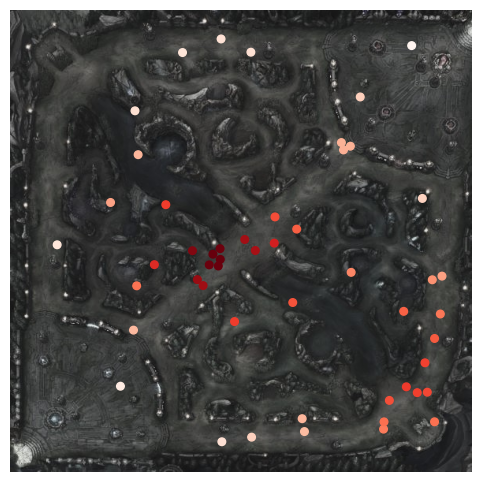

bottom       17
jungle       12
mid          12
top           5
red_zone      4
blue_zone     1
Name: lane, dtype: int64

In [ ]:
death_spot(wak_death_solo[wak_death_solo['timestamp'] >= 15])

wak_death_solo[wak_death_solo['timestamp'] >= 15]['lane'].value_counts()

In [ ]:
wak_death_solo['group'] = 1
wak_death_solo.loc[wak_death_solo['timestamp'] >= 15, 'group'] = 2


<ipython-input-156-db4382886423>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wak_death_solo['group'] = 1


In [ ]:
wak_death_solo['group'].value_counts()

2    51
1    42
Name: group, dtype: int64

damm.. 라인전 이후에 잘리는 경우가 월등히 더많다

* 그렇다면 라인전 이후에는 주로 어디서 잘리는 걸까?

In [ ]:
# 라인을 머문 점수 계산
def calculate_lane(x, y):
    top_ranges = [(500, 2000, 6000, 14000),(600, 9000, 13000, 14500), (1900,4500,11100,13100)]

    bottom_ranges = [(6000, 14000, 500, 2000),(13000,14500, 500,9000),(10500,13000,2000,3800)]

    mid_ranges = [(4500, 6000, 4500, 6000),(5200,6700,5200,6700),(5900,7400,5900,7400),(6000,8500,6000,8500),
                  (7300,8800,7300,8800),(8000,9500,8000,9500),(8700,10200,8700,10200),(9200,10500,9200,10500)]

    blue_zone = [(0,4500,0,4500)]
    red_zone = [(10500,15000,10500,15000)]

    for range_ in top_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'top'
    for range_ in mid_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'mid'
    for range_ in bottom_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'bottom'
    for range_ in blue_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'blue_zone'
    for range_ in red_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'red_zone'
    return 'jungle' # 나머지는 jungle


In [ ]:
wak_death_log.loc[:, 'lane'] = wak_death_log.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)
wak_death_log

* 좌표를 먼저 시각화해보자
* 아래는 15분 이후 솔로킬로 잘린 경우이다.
> 특히, 바텀라인에서 짤리는 경우가 많은것을 볼 수 있다. 아무래도 라인전(미드) 이후 바텀라인과 스왑하고 사이드를 미는 경우가 많은데, 이 때 표적이 되기 쉽다.

In [ ]:
df = wak_death_solo[wak_death_solo['group'] == 2]

In [ ]:
df['lane'].value_counts()

bottom       20
jungle       13
mid           7
blue_zone     5
top           4
red_zone      2
Name: lane, dtype: int64

In [ ]:
# 상대정글로 인한 데스
jungle_death_15 = jungle_death[jungle_death['timestamp'] < 16]
jungle_death_16 = jungle_death[jungle_death['timestamp'] > 15]
jungle_death_15.loc[:, 'lane'] = jungle_death_15.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)


<ipython-input-168-eea9d5a0b9f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jungle_death_15.loc[:, 'lane'] = jungle_death_15.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)


In [ ]:
jungle_death_15['lane'].value_counts()

jungle    95
bottom    79
top       46
mid       40
Name: lane, dtype: int64

(15분 이후) 미드라이너의 경우 라인전이 끝나고 사이드를 미는 경우가 많다. 해당 summoner 또한 바텀이나 정글지역에서 짤리는 경우가 많은것을 볼 수 있다.

# ABOUT 정글

#### 15분 이전 (라인전)
* 확실히 정글지역 (바론,드래곤) 에서 의 접점이 가장 많음
* 라인적으로는 바텀에서 가장 많이 접점이 일어남

이 두개의 위치 모두 '미드'의 합류가 어떻게보면 중요한 요소이기도 합니다. 왜냐하면 바론, 드래곤 모두 유리하게 관여할 수 있는 라인이기 때문이죠

그렇다면 혹시 합류하는 차이가 있을까?  하지만 이 합류차이라는 가설을 증명하기 위한 지표가 뭐가있을까?

* 정글지역에서 일어난 death log (상대 jungle 이 뭍은)
* 해당 death log의 딜교환 로그


> 좀 애매하다. 정글을 주 포지션으로 선택한 듀오력에 쓰는게 낫겟다.

In [ ]:
wakteam_death_log.loc[:, 'lane'] = wakteam_death_log.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)

wakteam_death_log[wakteam_death_log['timestamp'] < 16 ]['lane'].value_counts()

bottom    258
jungle    132
top       108
mid       102
Name: lane, dtype: int64

In [ ]:
wakteam_death_log.loc[:, 'lane'] = wakteam_death_log.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)
all_jungle_death = wakteam_death_log[(wakteam_death_log['timestamp']<16) & (wakteam_death_log['lane']== 'jungle')]



In [ ]:
#  라인전동안 상대정글의 assist,kill 이 들어간 data
# 그중 정글지역에서 일어난 log만 가져온다.
# 그리고 합류 여부를 보기위해서 assit 가 없는 경우는 제외

jungle_zone_death = jungle_death_15[(jungle_death_15['lane'] == 'jungle') & (jungle_death_15['assistingParticipantIds'].notna() )]
jungle_zone_death.head()

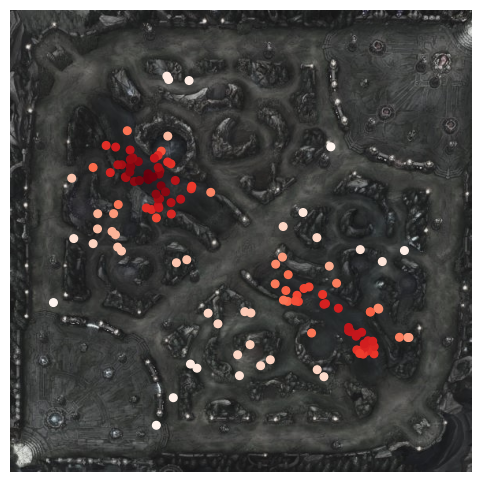

[JUNGLE]                          21
[MIDDLE]                          15
[TOP, JUNGLE]                      9
[UTILITY]                          9
[TOP]                              9
[TOP, MIDDLE]                      7
[BOTTOM]                           7
[JUNGLE, MIDDLE]                   6
[JUNGLE, UTILITY]                  5
[JUNGLE, BOTTOM, UTILITY]          2
[MIDDLE, BOTTOM]                   2
[BOTTOM, UTILITY]                  2
[TOP, BOTTOM, UTILITY]             2
[MIDDLE, UTILITY]                  2
[JUNGLE, BOTTOM]                   2
[TOP, UTILITY]                     1
[BOTTOM, TOP, UTILITY]             1
[TOP, BOTTOM]                      1
[JUNGLE, MIDDLE, BOTTOM]           1
[TOP, JUNGLE, MIDDLE, UTILITY]     1
Name: assistingParticipantIds, dtype: int64

In [ ]:
death_spot(all_jungle_death)
all_jungle_death['assistingParticipantIds'].value_counts()

In [ ]:
# death_spot(jungle_zone_death)
# victimDamageDealt (죽기전 딜) 과 victimDamageReceived (받은 피해량) 을 비교해서 합류차이를 어느정도 유추할 수 있다!!

killer_dealt =  received_damage(jungle_death_15,'victimDamageReceived','killerPosition') # killer 가 가한 피해량 = vicitm이 받은 피해량
vicitim_dealt = received_damage(jungle_death_15,'victimDamageDealt','victimPosition') # vicitm 이 가한 피해량 = killer 가 받은 피해량

vicitim_dealt.head()

,matchId,timestamp,name,victimPosition,participantId,spellName,magicDamage,physicalDamage,trueDamage,totalDamage
0,KR_6915832445,7,Pantheon,MIDDLE,2,summonerdot,0,0,68,68
1,KR_6915832445,7,Pantheon,MIDDLE,2,pantheonq,0,109,0,109
2,KR_6915832445,7,Pantheon,MIDDLE,4,pantheonw,0,45,0,45
3,KR_6915832445,7,Pantheon,MIDDLE,4,pantheonq,0,115,0,115
0,KR_6915767550,6,Leona,UTILITY,2,leonasolarbarrier,15,0,0,15


In [ ]:
# 데미지로 집계
# 상대 정글과 상대 포지션의 합류
assit_deal= killer_dealt.groupby(['killerPosition']).agg(
    damage_by = pd.NamedAgg(column = 'totalDamage', aggfunc='count')
)
assit_deal

,damage_by
killerPosition,
BOTTOM,361
JUNGLE,1294
MIDDLE,512
TOP,314
UTILITY,216


In [ ]:
# 데미지, 스킬샷 카운트
# 우리팀 합류
vicitm_deal= vicitim_dealt.groupby(['victimPosition']).agg(
    damage_by = pd.NamedAgg(column = 'totalDamage', aggfunc='count')
)

vicitm_deal

,damage_by
victimPosition,
BOTTOM,177
JUNGLE,383
MIDDLE,222
TOP,266
UTILITY,197


## 우리팀 정글이 킬하는 경우?


In [ ]:
# team_info
team_info.columns =['matchId',	'teamId',	'killerId','summonerName','killerPosition','championName','win'] # 우리팀 킬

In [ ]:
wakteam_kill_log = pd.merge(kill_log, team_info, on=['matchId', 'killerId'], how='inner')

def replace_ids_with_names(ids ,match_id):

    if isinstance(ids, list):
        return [team_info.loc[(team_info['killerId'] == id) & (team_info['matchId'] == match_id), 'summonerName'].values[0] if pd.notna(id) else None for id in ids]
    else:
        return None

wakteam_kill_log['assistingParticipantIds'] = wakteam_kill_log.apply(lambda row: replace_ids_with_names(row['assistingParticipantIds'], row['matchId']), axis=1)

In [ ]:
# oppnent_info = team_info.copy()
# oppnent_info.columns = ['matchId', 'teamId','vicitmId','summonerName','championName','killerPosition','win']



In [ ]:
wakteam_kill_log.loc[:, 'lane'] = wakteam_kill_log.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)


In [ ]:
# 우리팀이 정글라인에서 킬하는 경우
all_kill_log_15 = wakteam_kill_log[(wakteam_kill_log['timestamp'] < 16) & (wakteam_kill_log['lane']=='jungle') & (wakteam_kill_log['assistingParticipantIds'].notna())]
all_kill_log_15['assistingParticipantIds'].value_counts()

# death_spot(all_kill_log_15)


[JUNGLE]                     17
[MIDDLE]                     12
[BOTTOM, UTILITY]            11
[JUNGLE, UTILITY]            10
[UTILITY]                     7
[MIDDLE, UTILITY]             7
[JUNGLE, MIDDLE]              4
[JUNGLE, MIDDLE, UTILITY]     3
[TOP]                         2
[JUNGLE, BOTTOM]              2
[MIDDLE, BOTTOM, UTILITY]     2
[TOP, MIDDLE, UTILITY]        1
[JUNGLE, BOTTOM, UTILITY]     1
[BOTTOM]                      1
[TOP, MIDDLE]                 1
[TOP, JUNGLE]                 1
[MIDDLE, BOTTOM]              1
[TOP, JUNGLE, BOTTOM]         1
Name: assistingParticipantIds, dtype: int64

#### 바텀학살자

In [ ]:
team_info

,matchId,teamId,killerId,summonerName,killerPosition,championName,win
5,KR_6923804876,200,6,The Nollan,TOP,Singed,True
6,KR_6923804876,200,7,아불편,JUNGLE,Poppy,True
7,KR_6923804876,200,8,상길짱,MIDDLE,Yasuo,True
8,KR_6923804876,200,9,메시아빠우왁굳,BOTTOM,Lucian,True
9,KR_6923804876,200,10,광안리 해파리,UTILITY,Zyra,True
...,...,...,...,...,...,...,...
240,KR_6909535501,100,1,hinghong,TOP,Volibear,False
241,KR_6909535501,100,2,돈까스,JUNGLE,Rengar,False
242,KR_6909535501,100,3,메시아빠우왁굳,MIDDLE,Zed,False
243,KR_6909535501,100,4,걸프렌드찾아요,BOTTOM,Lucian,False


In [ ]:
wak_kill_log = wakteam_kill_log[wakteam_kill_log['summonerName'] == summoner_name]# |  (wakteam_kill_log['assistingParticipantIds'].apply(lambda x: summoner_name in x if isinstance(x, list) else False))]


In [ ]:
kill_damage = damage(wak_kill_log)
kill_damage

,matchId,timestamp,championName,killerId,totalDamage,victimId
0,KR_6923804876,0.853450,Singed,6,86,5.0
1,KR_6923804876,0.853450,Singed,6,53,5.0
2,KR_6923804876,0.853450,Zyra,10,54,5.0
3,KR_6923804876,0.853450,Zyra,10,41,5.0
4,KR_6923804876,0.853450,Zyra,10,44,5.0
...,...,...,...,...,...,...
7,KR_6909535501,18.919783,Zed,3,127,7.0
8,KR_6909535501,18.919783,Zed,3,80,7.0
9,KR_6909535501,18.919783,Zed,3,101,7.0
10,KR_6909535501,18.919783,Zed,3,121,7.0


In [ ]:
opponent_info = remaining_data[['matchId','teamId','killerId','killerPosition']]
opponent_info.columns=['matchId','teamId','victimId','vicitmPosition']


wak_dmg_merged = pd.merge(kill_damage, opponent_info, on=['matchId', 'victimId'], how='inner')
wak_dmg_merged = pd.merge(wak_dmg_merged, team_info[['matchId','killerId','summonerName']], on=['matchId', 'killerId'], how='inner' )

wak_dmg_merged

,matchId,timestamp,championName,killerId,totalDamage,victimId,teamId,vicitmPosition,summonerName
0,KR_6923804876,0.853450,Singed,6,86,5.0,100,UTILITY,The Nollan
1,KR_6923804876,0.853450,Singed,6,53,5.0,100,UTILITY,The Nollan
2,KR_6923804876,26.545283,Singed,6,142,5.0,100,UTILITY,The Nollan
3,KR_6923804876,26.545283,Singed,6,557,5.0,100,UTILITY,The Nollan
4,KR_6923804876,26.545283,Singed,6,66,5.0,100,UTILITY,The Nollan
...,...,...,...,...,...,...,...,...,...
1777,KR_6909535501,18.919783,Swain,5,202,7.0,200,JUNGLE,버냄즈
1778,KR_6909535501,18.919783,Swain,5,116,7.0,200,JUNGLE,버냄즈
1779,KR_6909535501,18.919783,Swain,5,189,7.0,200,JUNGLE,버냄즈
1780,KR_6909535501,18.919783,Swain,5,36,7.0,200,JUNGLE,버냄즈


In [ ]:
# 바텀라인을 죽인 로그
wak_dmg_merged[wak_dmg_merged['vicitmPosition'].isin(['BOTTOM','UTILITY']) & (wak_dmg_merged['summonerName']== summoner_name)]



,matchId,timestamp,championName,killerId,totalDamage,victimId,teamId,vicitmPosition,summonerName
23,KR_6923804876,0.85345,Lucian,9,31,5.0,100,UTILITY,메시아빠우왁굳
24,KR_6923804876,0.85345,Lucian,9,33,5.0,100,UTILITY,메시아빠우왁굳
25,KR_6923804876,0.85345,Lucian,9,58,5.0,100,UTILITY,메시아빠우왁굳
26,KR_6923804876,0.85345,Lucian,9,20,5.0,100,UTILITY,메시아빠우왁굳
27,KR_6923804876,0.85345,Lucian,9,81,5.0,100,UTILITY,메시아빠우왁굳
...,...,...,...,...,...,...,...,...,...
1591,KR_6909622124,29.09145,Caitlyn,4,129,10.0,200,UTILITY,메시아빠우왁굳
1592,KR_6909622124,29.09145,Caitlyn,4,60,10.0,200,UTILITY,메시아빠우왁굳
1593,KR_6909622124,29.09145,Caitlyn,4,1602,10.0,200,UTILITY,메시아빠우왁굳
1594,KR_6909622124,29.09145,Caitlyn,4,166,10.0,200,UTILITY,메시아빠우왁굳


In [ ]:
match_info = match_info[(match_info['timePlayed'] >= 1200) & (match_info['timePlayed'] < 2500)]
champ_dealt = match_info[match_info['puuid'] == puuid][['championName','totalDamageDealtToChampions','damagePerMinute']]

champ_dealt.groupby(['championName']).agg({'totalDamageDealtToChampions':'mean'})

,championName,totalDamageDealtToChampions,damagePerMinute
8,Lucian,20064,513.509357
17,Zoe,14543,466.176263
22,Diana,35678,892.324874
37,Zed,24725,695.278807
47,Zed,18665,556.000466
52,Diana,20692,748.124545
87,Diana,29765,1053.761305
93,Caitlyn,18755,765.931627
107,Azir,26469,878.421701
122,Akali,24584,764.536701


# 💻 궁금한게 뭘까..?
챔피언별로 봐야할까.. 포지션별로 봐야할까.. 둘다보자! \

우왁굳 vs 여태까지 만난 미드라이너

## ✔️ 해당 summoner에 대한 분석
### ① 여태까지 만난 유저들과의 기본적인 지표비교
* 상대라이너와 비교
* 팀원평균과 비교
* 상대평균과 비교

### ② 왜 죽은 걸가? death 와 관련된 지표
* 라인전 동안 죽은 경우, 가장 개입이 많았던 상대 포지션은 누구일까?
* (솔로킬을 당한경우) 라인전 이후 나는 어디서 짤리는 걸까?

### ③ 왜 진걸까? (부제: 누가 죄인인가 )
* 만약 졌다면 어느라인이 터져서 진걸까?
* 초반과 후반으로 나눠서 분석할 수 있음
* 대표적인 지표로 death 로그와 gold 차이를 분석하면 될것같다
* 중간에 게임을 포기하고 나간 경우도 있음  (이 경우 탈주한 팀원을 만난 횟수를 추가)


> 패배한 경기에서 각 매치별로 15분전후 일어난 데스로그와 그에 따른 골드차이가 어느정도 나타나는지, 그래서 어떤 라인에 의해 게임이 터졌는지 확인해볼 수 있다!

### ④ 현재까지 합이 잘맞는 듀오는 누구일까?
> 합이 잘맞다는 기준을 무엇으로 볼것인가
* 기본적인 지표, 라인전 캐리력, 한타 캐리력, 현재까지의 승률
* summoner 와 상호작용을 통해 가장 많은 kill,assist 성과를 달성한 멤버?

---

## 📊 대시보드 구성

>  ### summoner_INFO
*  summonerICON, summonerName, Rank, 승률, mostChamp,

> ### 패배한 경기 분석
*  누가 죄인인가? 최근 50경기중 패배한 경기를 기준, 15분 전후로 포지션별 골드차이를 시각화
* DEATH position : 라인전 이후 SOLO KILL을 가장 많이 당한 곳 (짤린곳)
*

> ### 듀오 측정기
*


In [ ]:
match_info.head(10)

,teamId,puuid,summonerName,participantId,teamPosition,challenges,summoner1Id,summoner2Id,championName,lane,kills,deaths,assists,totalMinionsKilled,neutralMinionsKilled,goldEarned,goldSpent,champExperience,item0,item1,item2,item3,item4,item5,item6,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,damageDealtToTurrets,damageDealtToBuildings,totalTimeSpentDead,longestTimeSpentLiving,visionScore,win,timePlayed,damageSelfMitigated,totalDamageShieldedOnTeammates,totalHealsOnTeammates,damageDealtToObjectives,soloKills,multikills,abilityUses,damageTakenOnTeamPercentage,skillshotsDodged,skillshotsHit,enemyChampionImmobilizations,laneMinionsFirst10Minutes,controlWardsPlaced,visionScorePerMinute,wardTakedowns,effectiveHealAndShielding,dragonTakedowns,baronTakedowns,teamBaronKills,alliedJungleMonsterKills,enemyJungleMonsterKills,epicMonsterKillsNearEnemyJungler,getTakedownsInAllLanesEarlyJungleAsLaner,jungleCsBefore10Minutes,junglerTakedownsNearDamagedEpicMonster,kda,killsOnOtherLanesEarlyJungleAsLaner,moreEnemyJungleThanOpponent,takedownsBeforeJungleMinionSpawn,junglerKillsEarlyJungle,killsOnLanersEarlyJungleAsJungler,totalCS,matchId,totalCS10Minutes
0,100,fHWB3mif-L5EVhN7LsbfHq2Ydma2E-de-GlwpMGayPCGsX...,dfjkgbkbdfs77,1,TOP,"{'12AssistStreakCount': 0, 'abilityUses': 297,...",14,4,Teemo,JUNGLE,5,12,3,230,31,17239,17100,22882,3089,6653,3020,3118,4646,4645,3340,307794,55452,42341,9350,9350,596,424,23,패배,2908,19076,0,0,21015,4,0,297,0.221925,6,0,0,62,0,0.477476,3,0.000000,0,1,1,2,5,1,0.0,2.00,0,0.666667,0.0,0.0,0,NaN,NaN,261,KR_6897386016,64.00
1,100,SJ45Oocwzn389g6QY2eLcJzzVAtlfAfelvoJtTncr_rA6e...,The Nollan,2,JUNGLE,"{'12AssistStreakCount': 0, 'abilityUses': 426,...",11,4,JarvanIV,JUNGLE,8,6,8,107,176,18139,17250,21262,3161,6333,3071,3156,6610,3111,3364,399873,20357,57342,2103,2103,232,853,42,패배,2908,113202,0,0,51835,1,0,426,0.300549,13,0,25,2,2,0.882718,11,0.000000,2,1,1,62,38,0,NaN,58.15,0,2.666667,NaN,-19.2,0,0.0,1.0,283,KR_6897386016,60.15
2,100,ELaIdl9QqdjENlnKDGbAmYAVxyYAZdcBtIV36Ymwlfkr3W...,메시아빠우왁굳,3,MIDDLE,"{'12AssistStreakCount': 0, 'abilityUses': 505,...",4,14,Zoe,MIDDLE,2,10,5,187,0,12697,11850,18981,6655,4646,3020,4645,2022,1026,3340,182345,28824,29153,3576,3576,339,461,24,패배,2908,9923,0,172,6286,0,0,505,0.152802,4,67,23,41,0,0.499818,1,172.270752,1,0,1,1,0,0,0.0,0.00,0,0.700000,0.0,0.0,0,NaN,NaN,187,KR_6897386016,41.00
3,100,TMRpbFIR4aP_kZVrfDIRY6XRUt9D3xr2vBhSdzpRE_MtK9...,개si발놈들,4,BOTTOM,"{'12AssistStreakCount': 0, 'abilityUses': 354,...",14,4,Lucian,BOTTOM,3,3,3,388,24,20012,25410,21301,6675,3095,3094,6672,3036,3158,3363,431134,27961,30131,4029,4029,142,1734,68,패배,2908,22398,0,0,19397,2,0,354,0.157928,18,24,0,63,4,1.417558,6,0.000000,2,1,1,3,1,0,0.0,0.00,0,2.000000,0.0,0.0,0,NaN,NaN,412,KR_6897386016,63.00
4,100,426gqu0wDVe8ChV4K9yP7T8EIimWAvZ1HJPpH0rqJgIMlw...,빵좀사주세요,5,UTILITY,"{'12AssistStreakCount': 0, 'abilityUses': 152,...",4,7,Brand,BOTTOM,4,7,4,59,0,12522,11875,14810,3871,6653,2421,3020,3118,3165,3364,75525,19392,31823,2069,2069,252,1019,107,패배,2908,11873,0,1016,8407,0,0,152,0.166797,18,6,3,14,9,2.223587,6,1016.000000,1,1,1,0,0,0,0.0,0.00,0,1.142857,0.0,0.0,0,NaN,NaN,59,KR_6897386016,14.00
5,200,y2Re1-BfwCu70OSYBhOe9Oaw9lUKpjgzJJWdPg-p5e1V6O...,영환이사냥꾼,6,TOP,"{'12AssistStreakCount': 1, 'abilityUses': 135,...",6,12,Thresh,TOP,3,2,14,171,0,13165,11925,21858,1029,3068,3075,3111,3110,8020,3340,100886,15997,31551,1375,1375,78,1152,31,승리,2908,56189,1943,0,3067,2,0,135,0.170345,14,21,70,41,1,0.653512,5,1943.592041,1,0,1,0,0,0,0.0,0.00,0,8.500000,0.0,0.0,0,NaN,NaN,171,KR_6897386016,41.00
6,200,4EdsfjfUbFzv7KYbdfgKaWAIQFt0WKT2TopqRkP_yoz_8Q...,요릭조지기과교수,7,JUNGLE,"{'12AssistStreakCount': 0, 'abilityUses': 426,...",11,4,Yorick,JUNGLE,9,4,9,201,167,22190,20183,27434,6610,3748,3078,6665,3181,3071,3364,528217,32875,50986,16716,16716,170,1159,32,승리,2908,46353,0,0,89014,2,1,426,0.275278,19,6,11,1,0,0.662627,14,0.000000,4,1,1,91,0,2,NaN,35.60,1,4.500000,NaN,-45.4,0,0.0,0.0,368,KR_6897386016,36.60
7,200,kLLmc3eLUlo6Ci-GQt

In [ ]:
# 패배한 경기 기준

champion_info = match_info[['matchId','teamId','participantId','summonerName','teamPosition','championName','win']]
# len(champion_info[(champion_info['summonerName'] == summoner_name) & (champion_info['teamPosition'] == 'MIDDLE')]) # 미드라이너로 간 경기 42개 (49경기중)
# champion_info

42

In [ ]:
# 매치아이디별 같은팀원들의 victimId 에 해당하는 데이터만 가져온다.
# 각 victimId 에 해당하는 participantId , 포지션, 결합
champion_info['summonerName'] = champion_info.apply(lambda row: row['championName'][:3] if row['summonerName'].strip() == '' else row['summonerName'], axis=1)
champion_info.columns=['matchId','teamId','victimId','summonerName','teamPosition','championName','win']


In [ ]:
champion_info

In [ ]:
# 매치아이디별로 본인 팀에 속한 teamId
wak_team = champion_info.loc[(champion_info['summonerName'] == summoner_name), ['matchId','teamId']]

# 왁굳팀만 가져오기
wak_team = pd.merge(wak_team, champion_info, on=['matchId', 'teamId'], how='inner')


In [ ]:
# 패배한 경기는 26경기 (49)
# 패배한 경기의 champion_INFO
wak_team_lose = wak_team[wak_team['win'] == '패배']
wak_team_lose

In [ ]:
# 팀원들의 데스로그
all_death_log = pd.merge(kill_log, wak_team_lose, on=['matchId', 'victimId'], how='inner')

In [ ]:
all_death_log.head()

,timestamp,type,position,teamId_x,killerId,victimId,assistingParticipantIds,victimDamageDealt,victimDamageReceived,matchId,teamId_y,summonerName,teamPosition,championName,win
0,2.900233,CHAMPION_KILL,"{'x': 12130, 'y': 2201}",NaN,4.0,10.0,[5],"[{'basic': False, 'magicDamage': 66, 'name': '...","[{'basic': False, 'magicDamage': 175, 'name': ...",KR_6884575817,200,무지개반사이응,UTILITY,Lux,패배
1,7.428850,CHAMPION_KILL,"{'x': 13544, 'y': 3644}",NaN,4.0,10.0,[5],"[{'basic': False, 'magicDamage': 65, 'name': '...","[{'basic': False, 'magicDamage': 278, 'name': ...",KR_6884575817,200,무지개반사이응,UTILITY,Lux,패배
2,15.471183,CHAMPION_KILL,"{'x': 12249, 'y': 2199}",NaN,5.0,10.0,[4],"[{'basic': False, 'magicDamage': 184, 'name': ...","[{'basic': True, 'magicDamage': 0, 'name': 'Mi...",KR_6884575817,200,무지개반사이응,UTILITY,Lux,패배
3,17.561667,CHAMPION_KILL,"{'x': 11230, 'y': 3804}",NaN,2.0,10.0,NaN,NaN,"[{'basic': False, 'magicDamage': 0, 'name': 'K...",KR_6884575817,200,무지개반사이응,UTILITY,Lux,패배
4,18.573967,CHAMPION_KILL,"{'x': 13539, 'y': 6399}",NaN,3.0,10.0,[5],"[{'basic': False, 'magicDamage': 134, 'name': ...","[{'basic': True, 'magicDamage': 0, 'name': 'Ne...",KR_6884575817,200,무지개반사이응,UTILITY,Lux,패배


In [ ]:
# 팀원들의 데스 로그
position_by_death = all_death_log[all_death_log['timestamp'] < 15].groupby(['teamPosition']).agg({'type':'count'}).reset_index()
position_by_death

,teamPosition,type
0,BOTTOM,63
1,JUNGLE,65
2,MIDDLE,59
3,TOP,80
4,UTILITY,65


In [ ]:
# 팀원들의 킬 로그
wak_team_lose.columns = ['matchId',	'teamId',	'killerId','summonerName', 'teamPosition',	'championName',	'win']
all_kill_log = pd.merge(kill_log, wak_team_lose, on=['matchId', 'killerId'], how='inner')

position_by_kill = all_kill_log[all_kill_log['timestamp'] < 15].groupby(['teamPosition']).agg({'type':'count'})
position_by_kill

,type
teamPosition,
BOTTOM,46
JUNGLE,58
MIDDLE,51
TOP,43
UTILITY,36


In [ ]:
# 데미지로 집계 (받은피해량) - 데스 기준
def received_damage(all_death_log):
  death_list = []
  if not all_death_log.empty:
      for d, ts, id, p in zip(all_death_log['victimDamageReceived'], all_death_log['timestamp'],all_death_log['matchId'],all_death_log['teamPosition']):
          df = pd.json_normalize(d)
          df['timestamp'] = ts
          df['matchId'] = id
          df['teamPosition'] = p
          death_list.append(df)

      death_damage_log = pd.concat(death_list, axis=0)
      death_damage_log = death_damage_log[['matchId','timestamp','name','teamPosition','participantId','spellName','magicDamage','physicalDamage','trueDamage']]
      death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

  else:
      death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','teamPosition','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])

  return death_damage_log





In [ ]:
# 포지션별 15분 이전에 받은 피해량
before_15_death = death_damage_log[death_damage_log['timestamp'] < 15]
damage_by_position = before_15_death.groupby(['matchId','teamPosition']).agg({'totalDamage':'sum'}).sort_values(by=['matchId','totalDamage'], ascending=False)
damage_by_position['rank'] = damage_by_position.groupby('matchId')['totalDamage'].rank(ascending=False, method='min')
damage_by_position

In [ ]:
# 데미지로 집계 (가한피해량) - 킬 기준

kill_lists = []
if not all_kill_log.empty:
    for d, ts, id, p in zip(all_kill_log['victimDamageReceived'], all_kill_log['timestamp'],all_kill_log['matchId'],all_kill_log['teamPosition']):
        df = pd.json_normalize(d)
        df['timestamp'] = ts
        df['matchId'] = id
        df['teamPosition'] = p
        kill_lists.append(df)

    kill_damage_log = pd.concat(kill_lists, axis=0)
    kill_damage_log = kill_damage_log[['matchId','timestamp','name','teamPosition','participantId','spellName','magicDamage','physicalDamage','trueDamage']]
    kill_damage_log['name'] = kill_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

else:
    kill_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','teamPosition','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])


kill_damage_log['totalDamage'] = kill_damage_log['magicDamage'] + kill_damage_log['physicalDamage'] + kill_damage_log['trueDamage']

In [ ]:
# 포지션별 15분 이전에 가한 피해량
before_15_kil = kill_damage_log[kill_damage_log['timestamp'] < 15]
kill_by_position = before_15_kil.groupby(['matchId','teamPosition']).agg({'totalDamage':'sum'}).sort_values(by=['matchId','totalDamage'], ascending=False)
kill_by_position['rank'] = kill_by_position.groupby('matchId')['totalDamage'].rank(ascending=False, method='min')
kill_by_position

In [ ]:
rank1_counts_kill = kill_by_position[kill_by_position['rank'] == 1].groupby('teamPosition').size()
rank1_counts_damage = damage_by_position[damage_by_position['rank'] == 1].groupby('teamPosition').size()

print(rank1_counts_kill)
print(rank1_counts_damage)

teamPosition
BOTTOM     3
JUNGLE     8
MIDDLE     5
TOP        5
UTILITY    5
dtype: int64
teamPosition
BOTTOM      3
JUNGLE      3
MIDDLE      4
TOP        11
UTILITY     5
dtype: int64


* 패배한 경기 중, 15분이전에 가장 많은 데미지를 받고 죽은 포지션 "TOP"

* 패배한 경기 중, 15분이전에 가장 많은 딜, 킬을한 포지션은 "JUNGLE"

# 경기, 팀별 골드 변화량

>  게임이 어느순간 부터 불리하게 돌아가는지 확인할 수 있는 대표적인 지표로 gold가 있다.  시간별로 gold 격차가 크게 차이나거나, 역전당하는 시점이 있다면 어떤 시점일까?

* 각 matchid, teamid, timestamp 를 groupby 해야함 ✔️

> 대시보드로 어떻게 표현할 것 인가?

* line chart : 본인 + 팀원평균 + 상대팀평균

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [ ]:
df = pd.concat(match_data_logs)
match_data_log = df[:6]

In [ ]:
# 모든 match 가 concat 된 frames 중 첫번쨰 timestamp data를 가져오면 아래와 같음
log1 = pd.DataFrame(df['info']['frames'][10])
log1

In [ ]:
frames_data = df['info']['frames']
matchId_data= df['metadata']['matchId']

all_data = pd.DataFrame()


# 'frames'의 각 데이터에 대해 반복
for i, frame in enumerate(frames_data):
    # 현재 프레임의 데이터 추출
    frame_data = pd.DataFrame(frame)

    # 현재 프레임의 데이터에 matchId 추가
    frame_data['matchId'] = matchId_data[i]

    # 현재 프레임의 데이터를 기존 데이터프레임에 추가
    all_data = pd.concat([all_data, frame_data])

# all_data

In [ ]:
frames_list = pd.DataFrame(all_data['participantFrames'])['participantFrames'].tolist()

In [ ]:
all_data.head(100)

In [ ]:
unique_match_ids = all_data['matchId'].unique()

# 모든 결과를 저장할 리스트 생성
final_result = []

for match_Id in unique_match_ids:
    # match_Id에 해당하는 데이터만 추출
    match_data = all_data[all_data['matchId'] == match_Id]
    timestamp = match_data['timestamp']

    # participantFrames 데이터 처리
    frames_list = pd.DataFrame(match_data['participantFrames'])['participantFrames'].tolist()
    participant_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    moving_data = [[] for _ in range(len(participant_ids))]

    for frame in frames_list:
        for i, participant_id in enumerate(participant_ids):
            if str(participant_id) in frame:
                moving_data[i].append(frame[str(participant_id)])

    moving_dfs = [pd.DataFrame(md) for md in moving_data]
    # moving = pd.concat(moving_dfs, ignore_index=True)

    # 시간 정보 , match_Id 열 추가
    for i, moving_df in enumerate(moving_dfs):
        moving_df['timestamp'] = timestamp / 60000
        moving_df['matchId'] = match_Id

    # 결과를 리스트에 추가
    final_result.extend(moving_dfs)

# 모든 결과를 합쳐서 최종 데이터프레임 생성
final_result_df = pd.concat(final_result, ignore_index=True)


In [ ]:
# GOLD 와 관련된 컬럼
gold = final_result_df[['matchId','timestamp','participantId','position','totalGold','xp','level']]
# gold.head(100)

In [ ]:
final_result_df.head()

,championStats,currentGold,damageStats,goldPerSecond,jungleMinionsKilled,level,minionsKilled,participantId,position,timeEnemySpentControlled,totalGold,xp,timestamp,matchId
0,"{'abilityHaste': 0, 'abilityPower': 0, 'armor'...",500,"{'magicDamageDone': 0, 'magicDamageDoneToChamp...",0,0,1,0,1,"{'x': 554, 'y': 581}",0,500,0,0.000000,KR_6918757013
1,"{'abilityHaste': 0, 'abilityPower': 0, 'armor'...",0,"{'magicDamageDone': 0, 'magicDamageDoneToChamp...",0,0,1,0,1,"{'x': 12120, 'y': 4647}",0,500,0,1.000367,KR_6918757013
2,"{'abilityHaste': 0, 'abilityPower': 0, 'armor'...",84,"{'magicDamageDone': 0, 'magicDamageDoneToChamp...",0,0,1,3,1,"{'x': 2015, 'y': 12324}",6504,584,185,2.000633,KR_6918757013
3,"{'abilityHaste': 0, 'abilityPower': 0, 'armor'...",339,"{'magicDamageDone': 0, 'magicDamageDoneToChamp...",0,0,3,11,1,"{'x': 2629, 'y': 13023}",29651,839,924,3.000900,KR_6918757013
4,"{'abilityHaste': 0, 'abilityPower': 0, 'armor'...",497,"{'magicDamageDone': 791, 'magicDamageDoneToCha...",0,0,4,13,1,"{'x': 1584, 'y': 13061}",67364,997,1416,4.001367,KR_6918757013


In [ ]:
champion_info = champion_info[['matchId','participantId','teamId','teamPosition','summonerName','championName','win']]

In [ ]:
gold_df = pd.merge(gold, champion_info, on=['matchId', 'participantId'], how='inner')
gold_df.head()

,matchId,timestamp,participantId,position,totalGold,xp,level,teamId,teamPosition,summonerName,championName,win
0,KR_6905652615,0.000000,1,"{'x': 554, 'y': 581}",500,0,1,100,TOP,분지울,Warwick,False
1,KR_6905652615,1.000333,1,"{'x': 6874, 'y': 11408}",500,0,1,100,TOP,분지울,Warwick,False
2,KR_6905652615,2.000900,1,"{'x': 1647, 'y': 12285}",563,185,1,100,TOP,분지울,Warwick,False
3,KR_6905652615,3.001167,1,"{'x': 1633, 'y': 12850}",797,671,3,100,TOP,분지울,Warwick,False
4,KR_6905652615,4.001217,1,"{'x': 2261, 'y': 11826}",1088,1284,4,100,TOP,분지울,Warwick,False


### 정글의 동선을 시각화해보자


In [ ]:
# 전체 데이터 merge

position_df = pd.merge(final_result_df, champion_info, on=['matchId', 'participantId'], how='inner')
position_df = position_df[['matchId','timestamp','participantId','teamId','position','xp','teamPosition','championName']]
position_df['timestamp'] = position_df['timestamp'].astype(int)
position_df.loc[:, 'lane'] = position_df.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)

jungle = position_df[position_df['teamPosition'] == 'JUNGLE']
blue_jungle = jungle[jungle['teamId'] == 100]
red_jungle = jungle[jungle['teamId'] == 200]

In [ ]:
jungle.head(10)

In [ ]:
final_result_df.head()

,championStats,currentGold,damageStats,goldPerSecond,jungleMinionsKilled,level,minionsKilled,participantId,position,timeEnemySpentControlled,totalGold,xp,timestamp,matchId
0,"{'abilityHaste': 0, 'abilityPower': 0, 'armor'...",500,"{'magicDamageDone': 0, 'magicDamageDoneToChamp...",0,0,1,0,1,"{'x': 554, 'y': 581}",0,500,0,0.000000,KR_6926495173
1,"{'abilityHaste': 0, 'abilityPower': 0, 'armor'...",0,"{'magicDamageDone': 0, 'magicDamageDoneToChamp...",0,0,1,0,1,"{'x': 1196, 'y': 9451}",0,500,0,1.000517,KR_6926495173
2,"{'abilityHaste': 0, 'abilityPower': 0, 'armor'...",42,"{'magicDamageDone': 19, 'magicDamageDoneToCham...",0,0,1,1,1,"{'x': 1804, 'y': 12083}",0,542,123,2.001000,KR_6926495173
3,"{'abilityHaste': 0, 'abilityPower': 0, 'armor'...",332,"{'magicDamageDone': 72, 'magicDamageDoneToCham...",0,0,3,11,1,"{'x': 1312, 'y': 10895}",2489,832,706,3.001567,KR_6926495173
4,"{'abilityHaste': 0, 'abilityPower': 0, 'armor'...",648,"{'magicDamageDone': 244, 'magicDamageDoneToCha...",0,0,4,20,1,"{'x': 1420, 'y': 11615}",5935,1148,1386,4.001767,KR_6926495173


어떻게 스토리를 짜야할까?


In [ ]:
import seaborn as sns

def death_spot(df):
    x_data = df['position'].apply(lambda pos: pos['x'])
    y_data = df['position'].apply(lambda pos: pos['y'])

    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 15000)
    ax.set_ylim(0, 15000)
    plt.axis('off')

    # 지도 이미지 추가
    map_path = "/content/map.jpg"
    img = Image.open(map_path)
    ax.imshow(img, extent=[0, 15000, 0, 15000])

    # Seaborn의 kdeplot으로 음영 추가
    sns.kdeplot(x=x_data, y=y_data, shade=True, cmap='Purples', ax=ax, alpha=0.2)

    # 산점도로 표시
    colors = np.where(df['teamId'] == 100, '#459ae5', 'Green')
    sc = ax.scatter(x_data, y_data, c=colors, alpha=0.7, s=30, edgecolors='none')

    plt.show()

In [ ]:
monster_kill_log

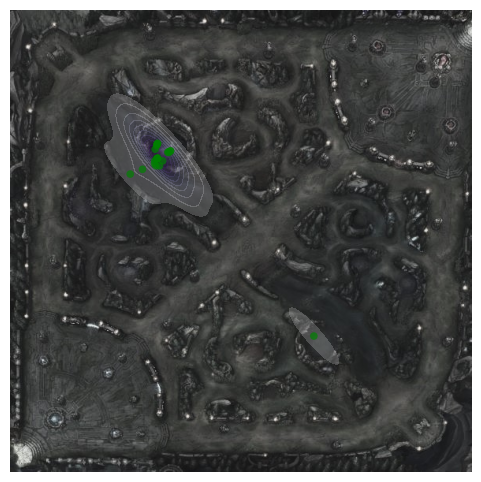

In [ ]:
df = jungle[jungle['timestamp'].isin([6])]
m10 = monster_kill_log[monster_kill_log['timestamp'] <= 6 ]


death_spot(m10)

# print(df['lane'].value_counts())
# wak_death_time['lane'].value_counts().plot.bar()

In [ ]:
x_data = jungle['position'].apply(lambda pos: pos['x'])
print(x_data)

<ipython-input-218-28b4ea0073f4>:42: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=timestamp_df['position'].apply(lambda pos: pos['x']),
<ipython-input-218-28b4ea0073f4>:42: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=timestamp_df['position'].apply(lambda pos: pos['x']),
<ipython-input-218-28b4ea0073f4>:42: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=timestamp_df['position'].apply(lambda pos: pos['x']),
<ipython-input-218-28b4ea0073f4>:42: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=timestamp_df['position'].apply(lambda pos: pos['x']),
<ipython-input-218-28b4ea0073f4>:42: UserWarning: KDE cannot be estimate

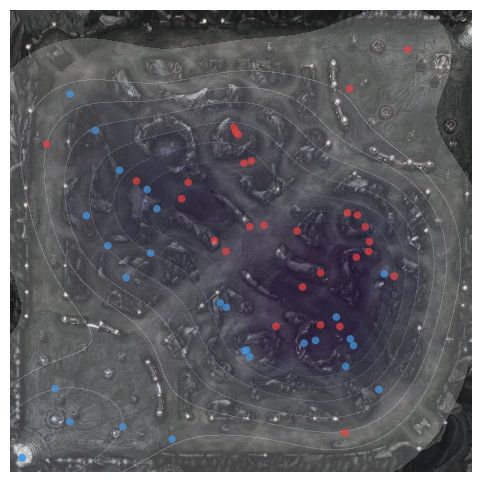

In [ ]:
from matplotlib.animation import FuncAnimation

def death_spot2(df):
    x_data = df['position'].apply(lambda pos: pos['x'])
    y_data = df['position'].apply(lambda pos: pos['y'])

    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 15000)
    ax.set_ylim(0, 15000)
    plt.axis('off')

    # 지도 이미지 추가
    map_path = "/content/map.jpg"
    img = Image.open(map_path)
    ax.imshow(img, extent=[0, 15000, 0, 15000])

    # Seaborn의 kdeplot으로 음영 추가
    sns.kdeplot(x=x_data, y=y_data, shade=True, cmap='Purples', ax=ax, alpha=0.2)

    # 산점도로 표시
    colors = np.where(df['teamId'] == 100, '#459ae5', '#ed4141')
    sc = ax.scatter(x_data, y_data, c=colors, alpha=0.7, s=30, edgecolors='none')

    def update(frame):
        timestamp = df['timestamp'].unique()[frame]
        timestamp_df = df[df['timestamp'] == timestamp]

        # Clear previous KDE plot
        ax.clear()

        # Set limits and axis properties
        ax.set_xlim(0, 15000)
        ax.set_ylim(0, 15000)
        plt.axis('off')

        # Add map image
        img = Image.open(map_path)
        ax.imshow(img, extent=[0, 15000, 0, 15000])

        # Plot new KDE plot for the current timestamp
        sns.kdeplot(x=timestamp_df['position'].apply(lambda pos: pos['x']),
                    y=timestamp_df['position'].apply(lambda pos: pos['y']),
                    shade=True, cmap='Purples', ax=ax, alpha=0.2)

        # Update the scatter plot for the current timestamp
        colors = np.where(timestamp_df['teamId'] == 100, '#459ae5', '#ed4141')
        sc = ax.scatter(timestamp_df['position'].apply(lambda pos: pos['x']),
                      timestamp_df['position'].apply(lambda pos: pos['y']),
                      c=colors, alpha=0.7, s=30, edgecolors='none')

        return sc,

    num_frames = 15
    ani = FuncAnimation(fig, update, frames=num_frames, interval=1000, blit=True)

    return ani

ani = death_spot2(jungle)
HTML(ani.to_jshtml())
ani.save('/content/jungle_anime3.gif', writer='imagemagick', dpi=300) # gif파일로 저장


In [ ]:
from IPython.display import HTML
HTML(ani.to_jshtml())



In [ ]:
blue_jungle[blue_jungle['lane'] == 'TOP']

In [ ]:
monster_log = p_df[p_df['type'] == 'ELITE_MONSTER_KILL']
monster_log['timestamp'] = monster_log['timestamp'] / 60000


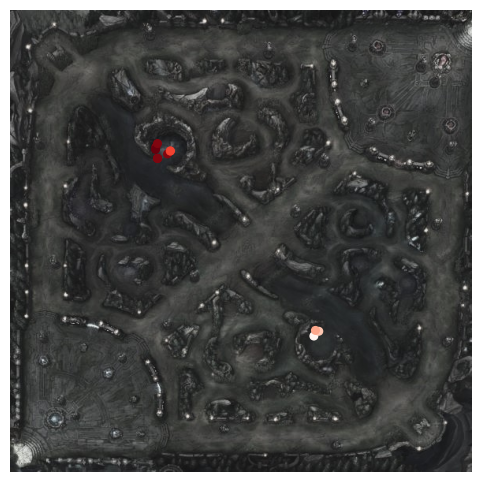

In [ ]:
death_spot(monster_log[monster_log['timestamp'] < 10 ])

* 게임마다 플레이 시간이 다르기 때문에 평균을 내기 애매하다.
* 그래도 15분 이상 게임이니, 확실한건 15분 이전 골드 상황을 비교할 수 있다.

### *idea1. 15분 이전까지 골드차이가 나면 지는 걸까?*

한타도 하기 전에 라인전이 터지면 골드차이가 많이나게 되어 지는경우가 대부분임..

* 우왁굳님이 패배한 경기를 분석해보았습니다. 라인전 동안 '각 라인별' 1분간의 골드변화량을 기준으로 급격하게 골드차이가 난 라인은 어디일까요? 바텀차이일까요?

* 패배한 경기를 기준으로 봐야할까? 이긴 경기는 어떻게?

In [ ]:
lose_match_list = champion_info[(champion_info['summonerName'] == summoner_name) & (champion_info['win']== False)]['matchId'].tolist()
lose_match_list

In [ ]:
lose_match_gold = gold_df[gold_df['matchId'].isin(lose_match_list)].groupby(['matchId','timestamp','win','teamPosition']).agg({'totalGold':'sum'}).reset_index()


NameError: name 'gold_df' is not defined

In [ ]:
lose_match_gold['timestamp'] = lose_match_gold['timestamp'].astype(int)

In [ ]:
# (15분, 라인전 동안) 포지션별 골드차이
line_lose = lose_match_gold[(lose_match_gold['timestamp'] >= 0) & (lose_match_gold['timestamp'] < 16)].sort_values(by=['matchId','timestamp','win'], ascending=[True,True,False])
line_lose['totalGold_diff'] = line_lose.groupby(['matchId','timestamp','teamPosition'])['totalGold'].diff()

#(경기가 끝나고)포지션별 골드차이
hanta_lose = lose_match_gold[lose_match_gold['timestamp'] >= 15].sort_values(by=['matchId','timestamp','win'], ascending=[True,True,False])
hanta_lose['totalGold_diff'] = hanta_lose.groupby(['matchId','timestamp','teamPosition'])['totalGold'].diff()
hanta_lose = hanta_lose.groupby('matchId').tail(5)

# line_lose[line_lose['win'] == False]

In [ ]:
# (이긴팀-진팀) 값이 - 일수록 차이가 많이난 포지션이다.
# line_lose_gold = line_lose.groupby(['matchId','teamPosition']).agg({'totalGold_diff':'sum'}).reset_index()  #(누적)
line_lose['rank'] = line_lose.groupby('matchId')['totalGold_diff'].rank(ascending=False, method='first')

# hanta_lose_gold = hanta_lose.groupby(['matchId','teamPosition']).agg({'totalGold_diff':'sum'}).reset_index()  #(누적)
hanta_lose['rank'] = hanta_lose.groupby('matchId')['totalGold_diff'].rank(ascending=False, method='first')


hanta_lose[hanta_lose['totalGold_diff'] < -2000]['teamPosition'].value_counts()

Series([], Name: teamPosition, dtype: int64)

In [ ]:
# most_common_ranks = t.groupby('teamPosition')['rank'].apply(lambda x: x.mode()[0]).reset_index()

# 라인전,한타 포지션별 평균 골드차이
avg_gold_by_position_line = line_lose.groupby(['teamPosition','timestamp'])['totalGold_diff'].mean().reset_index()
avg_gold_by_position_hanta = hanta_lose.groupby('teamPosition')['totalGold_diff'].mean().reset_index()

# 미드차이가 났지만 진 겯기
hanta_lose[(hanta_lose['teamPosition'] == 'MIDDLE')&(hanta_lose['totalGold_diff']>0)] #['totalGold_diff'].mean()

In [ ]:
avg_gold_by_position_line

In [ ]:
df = avg_gold_by_position_line[avg_gold_by_position_line['teamPosition'] != '']
df['totalGold_diff'] = df['totalGold_diff'].astype(int)

result = []
for team in df['teamPosition'].unique():
    team_data = {
        'id': team,
        'data': []
    }

    team_df = df[df['teamPosition'] == team]
    for index, row in team_df.iterrows():
        item = {
            'x': row["timestamp"],
            'y': row["totalGold_diff"]
        }
        team_data["data"].append(item)

    result.append(team_data)

result

# 듀오 스코어

* 왁굳님과 대표적으로 같이 게임을 한 멤버의 스코어를 구해보자
* 현재까지의 승률
* 모스트 라이너의 기본적인 지표(정글이면 상대정글과 비교)
* 기여도 : 우왁굳님의 킬에 어느정도 도움을 주었는지

In [ ]:
match_info['summonerName']

In [ ]:
# 우왁굳 == 돈까스 # The Nollan #

match_info['jungling'] = match_info['dragonTakedowns'] + match_info['baronTakedowns'] + match_info['enemyJungleMonsterKills']

In [ ]:
# 놀란,천양 매치
nollan_match = match_info[match_info['summonerName'] == 'The Nollan']['matchId'].tolist()
chun_match = match_info[match_info['summonerName'] =='돈까스']['matchId'].tolist()


In [ ]:
# 위 해당하는 매치만 가져와서 집계하면 됨

nol_match_info = match_info[match_info['matchId'].isin(nollan_match)]
chun_match_info = match_info[match_info['matchId'].isin(chun_match)]


In [ ]:
# 천양 포지션 정
match_info[match_info['summonerName'] =='돈까스']['teamPosition'].value_counts() #

JUNGLE     17
UTILITY     5
TOP         1
Name: teamPosition, dtype: int64

In [ ]:
# 놀란님의 듀오 주 포지션은 jungle 입니다.

# 지금까지 만난 상대정글과 비교를 해봅시다.
# 정글에 중요한 지표를 위주로!

# 전체적인 참여도 Radar chart
def radar_chart(match_info,summoner_name,position):

    summoner_match_info = match_info[(match_info['summonerName'] == summoner_name) & (match_info['teamPosition'] == position)]
    matchids = summoner_match_info['matchId'].tolist()
    other_line_info = match_info[(match_info['summonerName'] != summoner_name) & (match_info['matchId'].isin(matchids)) &(match_info['teamPosition'] == position)]

    # 왁굳님의 대표 게임지표 (평균)
    wak_score = summoner_match_info[['summonerName','visionScore','jungling','jungleCsBefore10Minutes',
                        'totalDamageDealtToChampions','damageDealtToBuildings']]
    opponent_score = other_line_info[['summonerName','visionScore','jungling','jungleCsBefore10Minutes',
                            'totalDamageDealtToChampions','damageDealtToBuildings']]

    wak_vs_df = pd.concat([wak_score,opponent_score])
    wak_vs_df.loc[wak_vs_df['summonerName']!= summoner_name, 'summonerName'] = '상대라이너'


    normalization_df = (wak_vs_df - wak_vs_df.min(numeric_only=True))/(wak_vs_df.max(numeric_only=True) - wak_vs_df.min(numeric_only=True))
    normalization_df['summonerName'] = wak_vs_df['summonerName']

    z = normalization_df.groupby(['summonerName']).agg(
        totalDamageDealtToChampions= pd.NamedAgg(column = 'totalDamageDealtToChampions', aggfunc='mean'),
        jungleCsBefore10Minutes = pd.NamedAgg(column = 'jungleCsBefore10Minutes', aggfunc='mean'),
        jungling = pd.NamedAgg(column = 'jungling', aggfunc='mean'),
        visionScore = pd.NamedAgg(column = 'visionScore', aggfunc='mean'),
        damageDealtToBuildings = pd.NamedAgg(column = 'damageDealtToBuildings', aggfunc='mean'),
    ).reset_index()

    z.columns =['summonerName','챔피언딜량','10분CS','정글링',
                        '시야점수','타워피해량']

    melted_df = pd.melt(z, id_vars=["summonerName"], var_name="var", value_name="value")
    pivoted_df = melted_df.pivot(index="var", columns="summonerName", values="value").reset_index()
    radar_data = pivoted_df.to_dict("records")


    return radar_data, opponent_score, wak_score, normalization_df



nol_radar, opponent_score, nol_score, nz = radar_chart(nol_match_info,'The Nollan','JUNGLE')
chun_radar, chopponent_score, chun_score , cz= radar_chart(match_info,'돈까스','JUNGLE')




In [ ]:
chun_radar

[{'var': '10분CS', '돈까스': 0.672807018218746, '상대라이너': 0.5997076025921203},
 {'var': '시야점수', '돈까스': 0.4791666666666667, '상대라이너': 0.4409722222222222},
 {'var': '정글링', '돈까스': 0.1884920634920635, '상대라이너': 0.30952380952380953},
 {'var': '챔피언딜량', '돈까스': 0.45544698107321885, '상대라이너': 0.3684531884383894},
 {'var': '타워피해량', '돈까스': 0.26145464373604177, '상대라이너': 0.21557205650151495}]

In [ ]:
# 놀란,천양 승패

print(nol_match_info[nol_match_info['summonerName'] == 'The Nollan']['win'].value_counts())
print(chun_match_info[(chun_match_info['summonerName'] == '우왁굳') | (chun_match_info['summonerName'] == '돈까스')]['win'].value_counts())

True     14
False     9
Name: win, dtype: int64


In [ ]:
# 전체 경기 놀란 기여도
info.columns=['matchId','teamId','killerId','summonerName','championName','killerPosition','win']
kill_assist = pd.merge(kill_log, info, on=['matchId','killerId'], how='inner')
wak_kill_log = kill_assist[kill_assist['summonerName'] == summoner_name]

In [ ]:
def replace_ids_with_names(ids, match_id):
    if isinstance(ids, list):
        return [info.loc[(info['killerId'] == id) & (info['matchId'] == match_id), 'summonerName'].values[0] if pd.notna(id) else None for id in ids]
    else:
        return None


# wak_kill_log['assistingParticipantIds'] = wak_kill_log.apply(lambda row: replace_ids_with_names(row['assistingParticipantIds'], row['matchId']), axis=1)
kill_assist['assistingParticipantIds'] = kill_assist.apply(lambda row: replace_ids_with_names(row['assistingParticipantIds'], row['matchId']), axis=1)


In [ ]:
# 듀오를 진행한 매치경기 중에서
# 놀란과 상호작용하여 킬한 로그 (우왁굳, 놀란 킬)
nol_kill_log = kill_assist[(kill_assist['matchId'].isin(nollan_match)) & (kill_assist['summonerName'] == summoner_name) | (kill_assist['summonerName'] == 'The Nollan')]

# 천양과 상호작용하여 킬한 로그 (우왁굳, 천양 킬)
chun_kill_log = kill_assist[(kill_assist['matchId'].isin(chun_match)) & (kill_assist['summonerName'] == summoner_name) | (kill_assist['summonerName'] == '돈까스')]





In [ ]:
nol_assist = nol_kill_log[nol_kill_log['assistingParticipantIds'].apply(lambda ids: '메시아빠우왁굳' in ids if isinstance(ids, list) else False or 'The Nollan' in ids if isinstance(ids, list) else False)]
chun_assist = chun_kill_log[chun_kill_log['assistingParticipantIds'].apply(lambda ids: '메시아빠우왁굳' in ids if isinstance(ids, list) else False or 'The Nollan' in ids if isinstance(ids, list) else False)]


In [ ]:
nol_assist

In [ ]:
# 자세한 데미지
nol_damage_log = damage(nol_kill_log)
nol_damage_log

# 와드와 관련하여..


* 소환사가 죽기전에 와드를 박고 죽었는지 확인해보자
* 15분이전과 15분 이후를 기점으로 와드를 박는 횟수의 차이가 있다면 와드를 잘 박지 않은 구간에 death가 더 많을까?


In [ ]:
ward_kill_15 = all_log[(all_log['type'] == 'WARD_KILL') & (all_log['timestamp'] <16)]

In [ ]:
# 죽은 좌표
wakteam_death_log.loc[:, 'lane'] = wakteam_death_log.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)


In [ ]:
# ward 에 대한 log champion_info 와 결합
ward_info = champion_info[['matchId','teamPosition','participantId','summonerName','win']]
ward_info.columns = ['matchId','teamPosition','creatorId','summonerName','win']
ward_log = pd.merge(kill_log, ward_info, on=['matchId','creatorId'],how='inner')
summoner_ward_log = ward_log[ward_log['summonerName'] == summoner_name][['matchId','timestamp','position','type','wardType','creatorId','killerId','victimId','summonerName','win']]


In [ ]:
def ward_death(summoner_name, wakteam_death_log ,summoner_ward_log, champion_info, timestamp):
  # 15분 전후 데스로그
  wak_death = wakteam_death_log[wakteam_death_log['victimSummoner'] == summoner_name]

  if timestamp == '15분전':
      wak_death = wak_death[wak_death['timestamp'] < 16]

      ward_static = summoner_ward_log[summoner_ward_log['timestamp'] < 16].groupby(['matchId','win']).agg(
          ward_cnt = pd.NamedAgg(column='wardType', aggfunc='count')
      ).reset_index()

      # n분  데스집계
      death_static = wak_death.groupby(['matchId']).agg(
        death_cnt = pd.NamedAgg(column='victimId',aggfunc='count')
      ).reset_index()


  elif timestamp == '15분이후':
      wak_death = wak_death[wak_death['timestamp'] > 15]
      ward_static = summoner_ward_log[summoner_ward_log['timestamp'] > 15].groupby(['matchId','win']).agg(
          ward_cnt = pd.NamedAgg(column='wardType', aggfunc='count')
      ).reset_index()

      # n분  데스집계
      death_static = wak_death.groupby(['matchId']).agg(
        death_cnt = pd.NamedAgg(column='victimId',aggfunc='count')
      ).reset_index()


  ward_death = pd.merge(ward_static, death_static , on=['matchId'],how= 'outer')
  ward_death['death_cnt'] = ward_death['death_cnt'].fillna(0).astype(int)

  return ward_death

In [ ]:
ward_death_15 = ward_death(summoner_name, wakteam_death_log , summoner_ward_log, champion_info, '15분전')
ward_death_16 = ward_death(summoner_name, wakteam_death_log , summoner_ward_log, champion_info, '15분이후')

In [ ]:
# 소환사가 라인전 동안 정글갱에 의해서 죽은 경우
# 와드를 박았을까!!!!!!!!!!!!!!?

wak_all_death = wakteam_death_log[(wakteam_death_log['victimSummoner'] == summoner_name) & (wakteam_death_log['timestamp'] < 16 )]
wak_death_gang = wak_all_death[(wak_all_death['killerId'] == 'JUNGLE') | (wak_all_death['assistingParticipantIds'].apply(lambda x: ('JUNGLE' in x) or ('TOP' in x) if isinstance(x, list) else False))]
wak_death_gang = wak_death_gang[['matchId','timestamp','type','wardType','position','assistingParticipantIds','victimSummoner','victimPosition','killerPosition','lane']]


static = wak_death_gang.groupby(['matchId']).agg(
    by_jungle_death = pd.NamedAgg(column='type', aggfunc='count')
)
static


,by_jungle_death
matchId,
KR_6907021547,1
KR_6909622124,2
KR_6909716665,1
KR_6909895917,1
KR_6911073913,1
KR_6911257292,1
KR_6912889593,1
KR_6915767550,1
KR_6918641204,1


In [ ]:
df = wak_death_gang[wak_death_gang['victimPosition'] == wak_death_gang['lane']]
df2 = summoner_ward_log[(summoner_ward_log['timestamp'] < 16) & (summoner_ward_log['matchId'].isin(df['matchId'].tolist()))]
df3 = ward_kill_15[ward_kill_15['matchId'].isin(df['matchId'].tolist())]

result = pd.concat([df,df2,df3], axis = 0).sort_values(by=['matchId','timestamp'], ascending=[True,True])

result[['matchId','timestamp','type','wardType','position','assistingParticipantIds','victimteam','victimSummoner','victimPosition','killerSummoner','killerteam','killerChampion','killerPosition','summonerName','lane']]

In [ ]:
# kill 에 대한 전체 로그
champion_info['victimId'] = champion_info['participantId']
champion_info['killerId'] = champion_info['participantId']
champion_info['creatorId'] = champion_info['participantId']

col = ['timestamp','type','wardType','position','killerId','victimId_x',
      'assistingParticipantIds','victimDamageDealt','victimDamageReceived',
      'matchId','teamId_y','summonerName','championName','teamPosition','win']

df = pd.merge(kill_log, champion_info , on = ['matchId','killerId'], how = 'inner')[col]
df.rename(columns={'victimId_x': 'victimId','teamId_y':'teamId','teamPosition':'killerPosition','summonerName':'killerSummoner'}, inplace=True)

df = pd.merge(df,champion_info, on = ['matchId','victimId'], how = 'left')[['timestamp','matchId','type','wardType','position','killerId_x','victimId','assistingParticipantIds',
                                                                                'victimDamageDealt','victimDamageReceived','teamId_x','killerSummoner','championName_x','killerPosition',
                                                                                'summonerName',	'championName_y',	'teamPosition',	'win_y'	,'killerId_y',	'creatorId']]
df.rename(columns={'killerId_x': 'killerId','teamId_x':'killerteam','championName_x':'killerChampion','championName_y':'victimChampion','summonerName':'victimSummoner','teamPosition':'victimPosition'}, inplace=True)


df.drop(['win_y','killerId_y','creatorId'], axis=1, inplace=True)
